<a href="https://colab.research.google.com/github/asantos2000/master-degree-santos-anderson/blob/main/code/src/chap_7_validation_rules_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validation

Validation of algorithms and transformation results.

Chap 7. Validação
- Section 7.3 Resultados
    - Section 7.3.2 Semantic Annotation
        - Classificação de regras operativas, fatos, termos e nomes
    - Section 7.3.3 nlp2sbvr

> With cumulative error (not replacing checkpoint with true table)

## Google colab

> Before run set your keys in `/content/.env` file and any preferences in `/content/config.yaml`, use the `.env.example` and `config.colab.yaml` of git repo as examples.

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  !git clone https://github.com/asantos2000/master-degree-santos-anderson.git cfr2sbvr
  %pip install -r cfr2sbvr/code/requirements.txt
  !mkdir -p /content/drive/MyDrive/cfr2sbvr
  !mkdir -p /content/drive/MyDrive/cfr2sbvr/outputs
  !cp -r cfr2sbvr/code/data /content/drive/MyDrive/cfr2sbvr
  !cp -r cfr2sbvr/code/src/logging_setup .
  !cp -r cfr2sbvr/code/src/rules_taxonomy_provider/ .
  !cp -r cfr2sbvr/code/src/llm_query/ .
  !cp -r cfr2sbvr/code/src/token_estimator/ .
  !cp -r cfr2sbvr/code/src/configuration .
  !cp -r cfr2sbvr/code/src/checkpoint .
  from dotenv import load_dotenv
  load_dotenv()
  DEFAULT_CONFIG_FILE="config.yaml"
else:
  DEFAULT_CONFIG_FILE="../config.yaml"

## Imports

In [2]:
# Standard library imports
import json
import os
import time
from datetime import datetime
from typing import List

# Third-party imports
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mi
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import rules_taxonomy_provider.main as rules_taxonomy_provider
import scipy.stats as stats
from scipy.spatial.distance import cosine
from scipy.stats import kendalltau, spearmanr, pearsonr, linregress
from openai import OpenAI
from pydantic import BaseModel, Field

# Local modules
import logging_setup.main as logging_setup
import configuration.main as configuration
import checkpoint.main as checkpoint
from checkpoint.main import (
  Document,
  DocumentProcessor,
  get_all_checkpoints,
  restore_checkpoint,
  save_checkpoint,
)
import llm_query.main as llm_query
from llm_query.main import query_instruct_llm
from rules_taxonomy_provider.main import RulesTemplateProvider

DEV_MODE = True

if DEV_MODE:
    # Development mode
    import importlib

    importlib.reload(configuration)
    importlib.reload(logging_setup)
    importlib.reload(checkpoint)
    importlib.reload(llm_query)
    importlib.reload(rules_taxonomy_provider)

# Ensure plots are displayed inline if using a Jupyter notebook
%matplotlib inline

## Settings

### Configuration

In [3]:
# Load configuration
config = configuration.load_config(DEFAULT_CONFIG_FILE)

### Logging

In [4]:
logger = logging_setup.setting_logging(config["DEFAULT_LOG_DIR"], config["LOG_LEVEL"])

2025-01-12 01:51:24 - INFO - Logging is set up with daily rotation.


## Checkpoints

### Restore the checkpoint

In [5]:
# Restore the checkpoint

# To run after extraction
last_checkpoint = configuration.get_last_filename(
    config["DEFAULT_CHECKPOINT_DIR"], "documents", "json"
)

logger.info(f"{last_checkpoint=}")

config["DEFAULT_CHECKPOINT_FILE"] = last_checkpoint

manager = restore_checkpoint(filename=config["DEFAULT_CHECKPOINT_FILE"])

2025-01-12 01:51:26 - INFO - last_checkpoint='../data/checkpoints/documents-2025-01-11-10.json'
2025-01-12 01:51:26 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-10.json
2025-01-12 01:51:26 - INFO - Checkpoint restored from ../data/checkpoints/documents-2025-01-11-10.json.


## General functions

In [6]:
# Summary statistics
def summary_statistics(df):
    return df.describe()

# Token usage analysis
def token_usage_analysis(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['total_tokens'], kde=True, bins=30)
    plt.title('Distribution of Total Tokens')
    plt.xlabel('Total Tokens')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='doc_type', y='total_tokens', data=df)
    plt.title('Total Tokens by Document Type')
    plt.xlabel('Document Type')
    plt.ylabel('Total Tokens')
    plt.xticks(rotation=45)
    plt.show()

# Time efficiency analysis
def time_efficiency_analysis(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['elapsed_time'], kde=True, bins=30)
    plt.title('Distribution of Elapsed Time')
    plt.xlabel('Elapsed Time (seconds)')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='elapsed_time', y='tokens_per_second', data=df)
    plt.title('Tokens per Second vs Elapsed Time')
    plt.xlabel('Elapsed Time (seconds)')
    plt.ylabel('Tokens per Second')
    plt.show()

# Cost analysis
def cost_analysis(df):
    df['cost'] = (df['total_tokens'] / 1_000_000) * df['price_per_million_tokens']
    logger.info(f"Total cost: ${df['cost'].sum():.2f}")

    plt.figure(figsize=(10, 6))
    sns.histplot(df['cost'], kde=True, bins=30)
    plt.title('Distribution of Execution Cost')
    plt.xlabel('Cost ($)')
    plt.ylabel('Frequency')
    plt.show()

# Temporal trends analysis
def temporal_analysis(df):
    df['created_date'] = df['created'].dt.date
    daily_usage = df.groupby('created_date').size()

    plt.figure(figsize=(10, 6))
    daily_usage.plot()
    plt.title('Daily Prompt Executions')
    plt.xlabel('Date')
    plt.ylabel('Number of Executions')
    plt.show()

# Group performance comparison
def group_performance_analysis(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='model', y='elapsed_time', data=df)
    plt.title('Elapsed Time by Model')
    plt.xlabel('Model')
    plt.ylabel('Elapsed Time (seconds)')
    plt.xticks(rotation=45)
    plt.show()

In [7]:
# Function to plot histogram for semscore and similarity_score side-by-side
def plot_histogram_side_by_side(df, title, xlabel, output_dir, filename):
    plt.figure(figsize=(12, 6))
    plt.hist(df["semscore"], bins=20, color="#D55E00", alpha=0.7, label="Semscore", linestyle="--", edgecolor="black")
    plt.hist(df["similarity_score"], bins=20, color="#0072B2", alpha=0.7, label="Similarity Score", linestyle="-", edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

    plot_path = os.path.join(output_dir, filename)
    plt.savefig(plot_path)
    plt.close()
    return plot_path

# Function to plot box plot for semscore and similarity_score side-by-side
def plot_boxplot_side_by_side(df, title, ylabel, output_dir, filename):
    plt.figure(figsize=(8, 6))
    boxplot = plt.boxplot(
        [df["semscore"].dropna(), df["similarity_score"].dropna()],
        labels=["Semscore", "Similarity Score"],
        patch_artist=True,
        boxprops=dict(color="black"),
        medianprops=dict(color="black"),
        capprops=dict(color="black"),
        whiskerprops=dict(color="black"),
    )
    colors = ["#D55E00", "#0072B2"]
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

    plot_path = os.path.join(output_dir, filename)
    plt.savefig(plot_path)
    plt.close()
    return plot_path

# Function to plot density plot for semscore and similarity_score side-by-side
def plot_density_side_by_side(df, title, xlabel, output_dir, filename):
    plt.figure(figsize=(12, 6))
    df["semscore"].plot(kind="kde", color="#D55E00", alpha=0.7, linestyle="--", label="Semscore")
    df["similarity_score"].plot(kind="kde", color="#0072B2", alpha=0.7, linestyle="-", label="Similarity Score")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    plot_path = os.path.join(output_dir, filename)
    plt.savefig(plot_path)
    plt.close()
    return plot_path

# Updated process_all_elements function

def process_all_elements_updated(element_data, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    excel_file_path = os.path.join(output_dir, "combined_analysis_results.xlsx")
    writer = pd.ExcelWriter(excel_file_path, engine="xlsxwriter")
    workbook = writer.book
    combined_df_list = []
    image_files = []

    for element_name, content in element_data.items():
        df = pd.DataFrame(content)
        numeric_cols = ["semscore", "similarity_score"]
        df[numeric_cols] = df[numeric_cols].astype(float)
        df["element_type"] = element_name
        combined_df_list.append(df)
        sheet_name = element_name[:31]
        worksheet = workbook.add_worksheet(sheet_name)
        writer.sheets[sheet_name] = worksheet
        row = 0

        # Histograms side-by-side
        plot_filename = f"histogram_side_by_side_{element_name}.png"
        plot_path = plot_histogram_side_by_side(
            df,
            f"Histograms of Semscore and Similarity Score - {element_name}",
            "Scores",
            output_dir,
            plot_filename,
        )
        worksheet.insert_image(row, 0, plot_path)
        row += 20
        image_files.append(plot_path)

        # Boxplots side-by-side
        plot_filename = f"boxplot_side_by_side_{element_name}.png"
        plot_path = plot_boxplot_side_by_side(
            df,
            f"Boxplots of Semscore and Similarity Score - {element_name}",
            "Scores",
            output_dir,
            plot_filename,
        )
        worksheet.insert_image(row, 0, plot_path)
        row += 20
        image_files.append(plot_path)

        try:
            # Density plots side-by-side
            plot_filename = f"density_side_by_side_{element_name}.png"
            plot_path = plot_density_side_by_side(
                df,
                f"Density Plots of Semscore and Similarity Score - {element_name}",
                "Scores",
                output_dir,
                plot_filename,
            )
            worksheet.insert_image(row, 0, plot_path)
            row += 20
            image_files.append(plot_path)
        except Exception as e:
            logger.error(f"Error plotting density side by side: {e}")

    combined_df = pd.concat(combined_df_list, ignore_index=True)

    # Combined Histograms side-by-side
    plot_filename = "histogram_side_by_side_combined.png"
    plot_path = plot_histogram_side_by_side(
        combined_df,
        "Combined Histograms of Semscore and Similarity Score",
        "Scores",
        output_dir,
        plot_filename,
    )
    writer.sheets["Combined"] = workbook.add_worksheet("Combined")
    writer.sheets["Combined"].insert_image(0, 0, plot_path)
    image_files.append(plot_path)

    # Combined Boxplots side-by-side
    plot_filename = "boxplot_side_by_side_combined.png"
    plot_path = plot_boxplot_side_by_side(
        combined_df,
        "Combined Boxplots of Semscore and Similarity Score",
        "Scores",
        output_dir,
        plot_filename,
    )
    writer.sheets["Combined"].insert_image(25, 0, plot_path)
    image_files.append(plot_path)

    # Combined Density Plots side-by-side
    plot_filename = "density_side_by_side_combined.png"
    plot_path = plot_density_side_by_side(
        combined_df,
        "Combined Density Plots of Semscore and Similarity Score",
        "Scores",
        output_dir,
        plot_filename,
    )
    writer.sheets["Combined"].insert_image(50, 0, plot_path)
    image_files.append(plot_path)

    writer.close()
    for image_file in image_files:
        if os.path.exists(image_file):
            os.remove(image_file)
    return combined_df


In [8]:
def remove_section_symbol(input_string: str) -> str:
    """
    Removes the '§' symbol from the input string and trims whitespace.

    Args:
        input_string (str): The string from which to remove the '§' symbol.

    Returns:
        str: The cleaned string without the '§' symbol and leading/trailing whitespace.

    Raises:
        TypeError: If 'input_string' is not a string.
    """
    if not isinstance(input_string, str):
        raise TypeError("input_string must be a string")
    return input_string.replace("§", "").strip()

In [9]:
def prompt_analysis(raw_data, output_dir):
    # Create a DataFrame from the raw data
    data = pd.DataFrame(
        raw_data,
        columns=["filename", "doc_type", "elapsed_time", "usage", "created", "model"],
    )

    # Transform 'created' to a human-readable datetime format
    data["created"] = pd.to_datetime(data["created"], unit="s")

    # Extract relevant information from the 'usage' dictionary
    data["completion_tokens"] = data["usage"].apply(lambda x: x["completion_tokens"])
    data["prompt_tokens"] = data["usage"].apply(lambda x: x["prompt_tokens"])
    data["total_tokens"] = data["usage"].apply(lambda x: x["total_tokens"])

    # Define a function to get reference model context length
    def get_reference_model_context_length(model):
        return reference_models.get(
            model, 128_000
        )  # Default to 128,000 if model is unknown

    # Define a function to get the price per million tokens
    def get_price_per_million_tokens(model):
        return price_per_million_tokens.get(
            model, 2.50
        )  # Default to 2.50 if model is unknown

    # Add context length and price per million tokens columns
    data["reference_context_length"] = data["model"].apply(
        get_reference_model_context_length
    )
    data["price_per_million_tokens"] = data["model"].apply(get_price_per_million_tokens)

    # Overall Statistics
    total_tokens = data["total_tokens"].sum()
    num_samples = len(data)
    average_elapsed_time = data["elapsed_time"].mean()
    estimated_cost = (
        data["total_tokens"] / 1_000_000 * data["price_per_million_tokens"]
    ).sum()
    average_percentage_context_length = (
        data["total_tokens"] / data["reference_context_length"]
    ).mean() * 100
    min_created = data["created"].min().strftime("%Y-%m-%d %H:%M:%S")
    max_created = data["created"].max().strftime("%Y-%m-%d %H:%M:%S")

    # Add filename column to each statistic for origin tracking
    filename = file_info["filename"]
    # Data and time of the execution
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Create Overall Statistics DataFrame
    overall_stats_df = pd.DataFrame(
        [
            {
                "Total Tokens": total_tokens,
                "Number of Samples": num_samples,
                "Average Elapsed Time (s)": average_elapsed_time,
                "Estimated Cost (USD)": estimated_cost,
                "Average Percentage of Context Length (%)": average_percentage_context_length,
                "Min Created Timestamp": min_created,
                "Max Created Timestamp": max_created,
                "origin": filename,
                "run_at": now,
            }
        ]
    )

    # Statistics by Sample Type (doc_type)
    stats_by_doc_type = (
        data.groupby("doc_type")
        .agg(
            total_tokens=("total_tokens", "sum"),
            num_samples=("doc_type", "count"),
            average_elapsed_time=("elapsed_time", "mean"),
            average_tokens=("total_tokens", "mean"),
            estimated_cost=(
                "total_tokens",
                lambda x: (x.sum() / 1_000_000)
                * data.loc[x.index, "price_per_million_tokens"].mean(),
            ),
            average_percentage_context_length=(
                "total_tokens",
                lambda x: (
                    x.mean() / data.loc[x.index, "reference_context_length"].mean()
                )
                * 100,
            ),
        )
        .reset_index()
    )
    stats_by_doc_type["filename"] = filename
    stats_by_doc_type["run_at"] = now

    # Statistics by Model
    stats_by_model = (
        data.groupby("model")
        .agg(
            total_tokens=("total_tokens", "sum"),
            num_samples=("model", "count"),
            average_elapsed_time=("elapsed_time", "mean"),
            average_tokens=("total_tokens", "mean"),
            average_percentage_context_length=(
                "total_tokens",
                lambda x: (x.mean() / get_reference_model_context_length(x.name)) * 100,
            ),
        )
        .reset_index()
    )
    stats_by_model["filename"] = filename
    stats_by_model["run_at"] = now

    # Add estimated cost and cost columns separately since they require different calculations
    def calculate_group_cost(model):
        price = get_price_per_million_tokens(model)
        total_tokens = data[data["model"] == model]["total_tokens"].sum()
        return (total_tokens / 1_000_000) * price

    stats_by_model["estimated_cost"] = stats_by_model["model"].apply(
        calculate_group_cost
    )
    stats_by_model["cost"] = stats_by_model["estimated_cost"]

    # Calculate Tokens per Second
    # Ensure there are no division by zero issues by filtering out zero elapsed times
    data = data[data["elapsed_time"] > 0]
    data["tokens_per_second"] = data["total_tokens"] / data["elapsed_time"]

    # Write the statistics to an Excel file
    file_name = os.path.join(output_dir, "prompt-analysis.xlsx")

    with pd.ExcelWriter(file_name, engine="openpyxl") as writer:
        # Replace the data on each sheet with the new data
        overall_stats_df.to_excel(writer, sheet_name="Overall Statistics", index=False)
        stats_by_doc_type.to_excel(
            writer, sheet_name="Statistics by Sample Type", index=False
        )
        stats_by_model.to_excel(writer, sheet_name="Statistics by Model", index=False)
        additional_stats_df = pd.DataFrame(
            [
                {
                    "Average Completion Tokens": data["completion_tokens"].mean(),
                    "Average Prompt Tokens": data["prompt_tokens"].mean(),
                    "Average Total Tokens per Sample": data["total_tokens"].mean(),
                    "Total Elapsed Time (s)": data["elapsed_time"].sum(),
                    "Average Tokens per Second": data["tokens_per_second"].mean(),
                    "origin": filename,
                    "run_at": now,
                }
            ]
        )
        additional_stats_df.to_excel(
            writer, sheet_name="Additional Statistics", index=False
        )
        data.to_excel(writer, sheet_name="Raw Data", index=False)

        # Explanation Page
        explanation_data = {
            "Sheet Name": [
                "Overall Statistics",
                "Statistics by Sample Type",
                "Statistics by Model",
                "Additional Statistics",
                "Raw Data",
            ],
            "Description": [
                "Summary statistics of the entire dataset, including total tokens, number of samples, average elapsed time, and estimated cost.",
                "Statistics broken down by sample type (doc_type), including the total number of tokens and cost estimates for each type.",
                "Statistics grouped by the model used, showing token utilization, cost, and elapsed time for each model.",
                "Additional aggregated metrics such as average completion tokens, prompt tokens, total tokens per sample, and processing time.",
                "The raw data used for generating all the statistics, including individual completions and their details.",
            ],
            "Columns Explained": [
                "Total Tokens: Total number of tokens processed. Number of Samples: Total number of samples. Average Elapsed Time (s): Average time taken for processing. Estimated Cost (USD): Estimated cost for token usage. Average Percentage of Context Length (%): Average percentage of used context length. Min and Max Created Timestamp: The time range of the data collected. Origin: Source filename.",
                "doc_type: Type of document. total_tokens: Sum of tokens per document type. num_samples: Number of samples of this type. average_elapsed_time: Average time taken per document type. average_tokens: Average tokens per sample. estimated_cost: Estimated cost for tokens of this type. average_percentage_context_length: Average percentage of context length used. filename: Source filename.",
                "model: Model name. total_tokens: Total number of tokens used by the model. num_samples: Number of samples processed by the model. average_elapsed_time: Average processing time for the model. average_tokens: Average number of tokens per sample. average_percentage_context_length: Average context length percentage used. filename: Source filename. estimated_cost/cost: Cost for the tokens used by the model.",
                "Average Completion Tokens: Average number of completion tokens per sample. Average Prompt Tokens: Average number of prompt tokens per sample. Average Total Tokens per Sample: Average number of total tokens per sample. Total Elapsed Time (s): Total processing time for all samples. Average Tokens per Second: Average number of tokens processed per second. origin: Source filename.",
                "filename: Source filename. doc_type: Type of document. elapsed_time: Time taken for each document. usage: Token usage details (completion and prompt). created: Timestamp of creation. model: Model used.",
            ],
        }
        explanation_df = pd.DataFrame(explanation_data)
        explanation_df.to_excel(writer, sheet_name="Explanation", index=False)

    # Display Overall Statistics
    overall_stats_df_display = pd.DataFrame(
        [
            {
                "Total Tokens": total_tokens,
                "Number of Samples": num_samples,
                "Average Elapsed Time (s)": average_elapsed_time,
                "Estimated Cost (USD)": estimated_cost,
                "Average Percentage of Context Length (%)": average_percentage_context_length,
                "Min Created Timestamp": min_created,
                "Max Created Timestamp": max_created,
                "origin": filename,
                "run_at": now,
            }
        ]
    )
    print("\nOverall Statistics:")
    print(overall_stats_df_display.to_string(index=False))

    # Display Statistics by Sample Type
    print("\nStatistics by Sample Type (doc_type):")
    print(stats_by_doc_type.to_string(index=False))

    # Display Statistics by Model
    print("\nStatistics by Model:")
    print(stats_by_model.to_string(index=False))

    # Additional Statistics
    additional_stats_df_display = pd.DataFrame(
        [
            {
                "Average Completion Tokens": data["completion_tokens"].mean(),
                "Average Prompt Tokens": data["prompt_tokens"].mean(),
                "Average Total Tokens per Sample": data["total_tokens"].mean(),
                "Total Elapsed Time (s)": data["elapsed_time"].sum(),
                "Average Tokens per Second": data["tokens_per_second"].mean(),
                "origin": filename,
                "run_at": now,
            }
        ]
    )
    print("\nAdditional Statistics:")
    print(additional_stats_df_display.to_string(index=False))

    return data

In [10]:
# Add similarity_classification based on similarity_score
def classify_similarity(score):
    if score == 1.0:
        return "identical"
    elif score >= 0.9:
        return "close-match"
    else:
        return "not-sure"


# Modify the highlight_similarity function to use three colors
def highlight_similarity(val):
    if val == "identical":
        color = "green"
    elif val == "close-match":
        color = "yellow"
    else:
        color = "red"
    return f"background-color: {color}"

In [11]:
def create_df_elements_results(similarity_elements_results):
    # Build the dataframe
    df_results = pd.DataFrame(similarity_elements_results)

    df_results["similarity_classification"] = df_results["similarity_score"].apply(
        classify_similarity
    )

    df_results["classification_match"] = (
        df_results["classification_pred"] == df_results["classification_true"]
    )
    df_results["classification_match_label"] = df_results["classification_match"].map(
        {True: "match", False: "mismatch"}
    )

    df_results["source_match"] = df_results["source_pred"] == df_results["source_true"]
    df_results["source_match_label"] = df_results["source_match"].map(
        {True: "match", False: "mismatch"}
    )

    df_results["id_match"] = df_results["id_pred"] == df_results["id_true"]
    df_results["id_match_label"] = df_results["id_match"].map(
        {True: "match", False: "mismatch"}
    )

    return df_results

In [12]:
class JudgeStatement(BaseModel):
    doc_id: str = Field(..., description="Document ID associated with the statement.")
    statement_id: str = Field(
        ...,
        description="A provided string that identifies the statement. e.g., '1', 'Person'.",
    )
    statement: str = Field(..., description="The statement to be transformed.")
    sources: List[str] = Field(..., description="Sources of the statement.")
    semscore: float = Field(..., description="just a copy from input semscore.")
    similarity_score: float = Field(
        ...,
        description="Similarity score between the original and transformed sentences.",
    )
    similarity_score_confidence: float = Field(
        ..., description="Confidence score for the similarity score."
    )
    transformation_accuracy: float = Field(
        ..., description="Accuracy score for the transformation."
    )
    grammar_syntax_accuracy: float = Field(
        ..., description="Accuracy score for the grammar and syntax."
    )
    findings: List[str] = Field(..., description="List of findings.")


class JudgeStatements(BaseModel):
    JudgeStatements: List[JudgeStatement] = Field(
        ..., description="List of judge statements."
    )

In [28]:
def get_prompts_for_judge(rules, data_dir):
    rule_template_provider = RulesTemplateProvider(data_dir)

    system_prompts = []
    user_prompts = []
    element_name = None

    for rule in rules:
        element_name = rule.get("element_name")

        if element_name == ["Term", "Name"]:
            statement_key = "definition"
            statement_id_key = "signifier"
        else:
            statement_key = "statement"
            statement_id_key = "statement_id"

        user_prompt = get_user_prompt_judge_sentence_similarity(element_name, rule)
        user_prompts.append(user_prompt)
        rule_templates_subtemplates = rule_template_provider.get_rules_template(
            rule["templates_ids"]
        )
        system_prompt = get_system_prompt_judge_sentence_similarity(
            rule_templates_subtemplates
        )
        system_prompts.append(system_prompt)
        logger.debug(system_prompt)
        logger.debug(user_prompt)

    logger.info(f"System prompts for {element_name}s: {len(system_prompts)}")
    logger.info(f"User prompts for {element_name}s: {len(user_prompts)}")

    return system_prompts, user_prompts, element_name

In [14]:
def evaluate_statement(element_name, user_prompts, system_prompts, manager):
    # Initialize an empty list to accumulate all responses
    all_responses = []
    elapse_times = []
    completions = []

    # Loop through each pair of user and system prompts with a counter
    for index, (user_prompt, system_prompt) in enumerate(
        zip(user_prompts, system_prompts), start=1
    ):
        logger.info(f"Processing evaluation prompt {index} for {element_name}.")
        logger.debug(system_prompt)
        logger.debug(user_prompt)

        # Query the language model
        response, completion, elapse_time = query_instruct_llm(
            system_prompt=system_prompt,
            user_prompt=user_prompt,
            document_model=JudgeStatements,
            llm_model=config["LLM"]["MODEL"],
            temperature=config["LLM"]["TEMPERATURE"],
            max_tokens=config["LLM"]["MAX_TOKENS"],
        )

        logger.debug(f"{response}")

        # Accumulate the responses in the list
        all_responses.extend(response.JudgeStatements)
        elapse_times.append(elapse_time)
        completions.append(completion.dict())

        logger.info(f"Finished processing evaluation {index}.")

        logger.info("Waiting 2s before processing the next prompt to avoid rate limits")
        time.sleep(2)

    # After the loop, create a single Document with all the accumulated responses
    doc = Document(
        id=f"validation_judge_{element_name.replace(' ', '_')}s",
        type="llm_validation",
        content=all_responses,
        elapsed_times=elapse_times,
        completions=completions,
    )
    manager.add_document(doc)

    logger.info(f"{element_name}s: {len(all_responses)}")

    return all_responses

In [15]:
def get_embedding(text, model="text-embedding-3-large"):
    client = OpenAI()
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding


def cosine_similarity(embedding1, embedding2):
    # Calcula a similaridade de cosseno entre dois embeddings
    embedding1 = np.array(embedding1)
    embedding2 = np.array(embedding2)
    cos_sim = np.dot(embedding1, embedding2) / (
        np.linalg.norm(embedding1) * np.linalg.norm(embedding2)
    )
    return cos_sim


def compare_sentences(sentence1, sentence2):
    # Obtem embeddings para as duas frases
    embedding1 = get_embedding(sentence1)
    embedding2 = get_embedding(sentence2)
    # Calcula a similaridade de cosseno entre os embeddings
    # similarity = cosine_similarity(embedding1, embedding2)
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity

## Datasets

From section 7.2.4 Datasets

The dataset of the previous algorithm was adjusted with the gold standard dataset. The goal is to reduce the accumulation of errors from one step to the next.

The data adjusted:

- § 275.0-2_P1, § 275.0-2_P2
- § 275.0-5_P1, § 275.0-5_P2
- § 275.0-7_P1, § 275.0-7_P2

### True tables

There are no true tables to evaluate the transformation, the evaluation depends on the algorithms SEMSCORE and "LLM as a Judge".

### Predicted values

Get predicted elements from all runs

In [16]:
elements = []

managers, file_info_list = get_all_checkpoints(config["DEFAULT_CHECKPOINT_DIR"])

for manager, file_info in zip(managers, file_info_list):
    # Process documents
    processor = DocumentProcessor(manager, merge=True)

    # Access processed data
    elements.append(
        {"pred_facts": processor.get_rules(),
        "pred_terms": processor.get_facts(),
        "pred_names": processor.get_terms(definition_filter="non_null"),
        "pred_operative_rules": processor.get_names(definition_filter="non_null"),
        "pred_file_info": file_info}
    )

2025-01-12 01:51:40 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-1.json
2025-01-12 01:51:40 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-10.json
2025-01-12 01:51:40 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-2.json
2025-01-12 01:51:40 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-3.json
2025-01-12 01:51:40 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-4.json
2025-01-12 01:51:40 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-5.json
2025-01-12 01:51:40 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-6.json
2025-01-12 01:51:40 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-7.json
2025-01-12 01:51:40 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-

2025-01-12 01:51:40 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-9.json
2025-01-12 01:51:40 - WARNING - Document 'classify_P2_Definitional_names' not found or has empty content.
2025-01-12 01:51:40 - WARNING - Document 'transform_Names' of type 'llm_response_transform' not found or empty.
2025-01-12 01:51:40 - WARNING - Validation document 'validation_judge_Operative_Rules' not found or empty.
2025-01-12 01:51:40 - WARNING - Validation document 'validation_judge_Fact_Types' not found or empty.
2025-01-12 01:51:40 - WARNING - Validation document 'validation_judge_Terms' not found or empty.
2025-01-12 01:51:40 - WARNING - Validation document 'validation_judge_Names' not found or empty.
2025-01-12 01:51:40 - WARNING - Document 'classify_P2_Definitional_names' not found or has empty content.
2025-01-12 01:51:40 - WARNING - Document 'transform_Names' of type 'llm_response_transform' not found or empty.
2025-01-12 01:51:40 - WARNING - Validation docum

Set dataset to evaluation and check empty transformed elements

In [17]:
for element_item in elements:
    for key in element_item.keys():
        if key == "pred_file_info":
            continue
        empty_transformed_elements = [
            item for item in element_item[key] if not item.get("transformed")
        ]
        logger.info(
            f'Empty transformed {element_item["pred_file_info"].get("filename")} {key}: {len(empty_transformed_elements)}/{len(element_item[key])}'
        )

2025-01-12 01:52:00 - INFO - Empty transformed documents-2025-01-11-1.json pred_facts: 0/1
2025-01-12 01:52:00 - INFO - Empty transformed documents-2025-01-11-1.json pred_terms: 0/21
2025-01-12 01:52:00 - INFO - Empty transformed documents-2025-01-11-1.json pred_names: 0/10
2025-01-12 01:52:00 - INFO - Empty transformed documents-2025-01-11-1.json pred_operative_rules: 0/0
2025-01-12 01:52:00 - INFO - Empty transformed documents-2025-01-11-10.json pred_facts: 0/7
2025-01-12 01:52:00 - INFO - Empty transformed documents-2025-01-11-10.json pred_terms: 0/16
2025-01-12 01:52:00 - INFO - Empty transformed documents-2025-01-11-10.json pred_names: 0/19
2025-01-12 01:52:00 - INFO - Empty transformed documents-2025-01-11-10.json pred_operative_rules: 0/0
2025-01-12 01:52:00 - INFO - Empty transformed documents-2025-01-11-2.json pred_facts: 0/5
2025-01-12 01:52:00 - INFO - Empty transformed documents-2025-01-11-2.json pred_terms: 0/19
2025-01-12 01:52:00 - INFO - Empty transformed documents-2025

Check missing values.

In [18]:
for element_item in elements:
    for key in element_item.keys():
        if key == "pred_file_info":
            continue
        element_df = pd.DataFrame(element_item[key])

        # Check if there are any missing values
        if element_df.isnull().any().any():
            mi.matrix(element_df, figsize=(10, 5))
            plt.title(f'Missing Values for {key} in {element_item["pred_file_info"].get("filename")}')
            plt.show()  # Ensure the plot displays
        else:
            logger.info(f'No missing values for {key} in {element_item["pred_file_info"].get("filename")}')

2025-01-12 01:52:09 - INFO - No missing values for pred_facts in documents-2025-01-11-1.json
2025-01-12 01:52:09 - INFO - No missing values for pred_terms in documents-2025-01-11-1.json
2025-01-12 01:52:09 - INFO - No missing values for pred_names in documents-2025-01-11-1.json
2025-01-12 01:52:09 - INFO - No missing values for pred_operative_rules in documents-2025-01-11-1.json


2025-01-12 01:52:09 - INFO - No missing values for pred_facts in documents-2025-01-11-10.json
2025-01-12 01:52:09 - INFO - No missing values for pred_terms in documents-2025-01-11-10.json
2025-01-12 01:52:09 - INFO - No missing values for pred_names in documents-2025-01-11-10.json
2025-01-12 01:52:09 - INFO - No missing values for pred_operative_rules in documents-2025-01-11-10.json
2025-01-12 01:52:09 - INFO - No missing values for pred_facts in documents-2025-01-11-2.json
2025-01-12 01:52:09 - INFO - No missing values for pred_terms in documents-2025-01-11-2.json
2025-01-12 01:52:09 - INFO - No missing values for pred_names in documents-2025-01-11-2.json
2025-01-12 01:52:09 - INFO - No missing values for pred_operative_rules in documents-2025-01-11-2.json
2025-01-12 01:52:09 - INFO - No missing values for pred_facts in documents-2025-01-11-3.json
2025-01-12 01:52:09 - INFO - No missing values for pred_terms in documents-2025-01-11-3.json
2025-01-12 01:52:09 - INFO - No missing values

## Algorithms

Validation of algorithm from section 6.2 Implementation of main components

Source for section 7.3 Results 

### nlp2sbvr

Elements measurements from chapter 7.2.3 Terms, names, facts, and operative rules

#### Measuring similarity with SEMSCORE

Evaluating SEMSCORE (AYNETDINOV;AKBIK, 2024) between the predicted and true statements for each element.

> WARNING: Expensive operation!


If the data is available could skip processing evaluation. Operation is expensive, if just need to compile the evaluation, set SKIP to True.

In [19]:
SKIP = False

In [20]:
if not SKIP:
    for element_item in elements:
        for key in element_item.keys():
            if key == "pred_file_info":
                continue
            for item in element_item[key]:
                original_sentence = f'{item.get("statement_id")}: {item.get("statement", item.get("definition"))}'
                transformed_sentence = item.get("transformed")
                templates_ids = item.get("templates_ids")
                element_name = item.get("element_name")

                logger.info(f"{original_sentence=}")
                logger.info(f"{transformed_sentence=}")
                logger.info(f"{templates_ids=}")
                logger.info(f"{element_name=}")
                logger.info(f"{key=}")
                logger.info(f'{element_item["pred_file_info"]=}')

                # Remove keys if they exist
                for key in [
                    "explanation",
                    "confidence",
                    "subtype_confidence",
                    "subtype_explanation",
                ]:
                    item.pop(key, None)  # Using pop with None to avoid KeyError

                logger.debug(f"{element_name=}")

                # Calculate similarity score
                similarity = compare_sentences(original_sentence, transformed_sentence)

                # Assign the calculated score to 'semscore'
                item["semscore"] = similarity
            else:
                logger.debug(
                    f"{item.get('element_name')} already has a semscore: {item['semscore']}"
                )

2025-01-12 01:52:36 - INFO - original_sentence='4: The Commission will order a hearing on the matter, if it appears that a hearing is necessary or appropriate in the public interest or for the protection of investors, upon the request of any interested person or upon its own motion.'
2025-01-12 01:52:36 - INFO - transformed_sentence='The Commission may order a hearing on the matter only if it appears that a hearing is necessary or appropriate in the public interest or for the protection of investors, upon the request of any interested person or upon its own motion.'
2025-01-12 01:52:36 - INFO - templates_ids=['T50']
2025-01-12 01:52:36 - INFO - element_name='Operative Rule'
2025-01-12 01:52:36 - INFO - key='pred_facts'
2025-01-12 01:52:36 - INFO - element_item["pred_file_info"]={'filename': 'documents-2025-01-11-1.json', 'date': '2025-01-11', 'number': 1}
2025-01-12 01:52:37 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-01-12 01:52:38 - INFO - 

Check if SEMSCORE was calculated.

In [21]:
for element_item in elements:
    for key in element_item.keys():
        if key == "pred_file_info":
            continue
        semscore_in_operative_rules = all(
            "semscore" in item and item["semscore"] is not None
            for item in element_item[key]
        )

        logger.info(
            f'{key} to evaluate: {len(element_item[key])}, semscore was calculated: {semscore_in_operative_rules}'
        )

2025-01-12 02:03:13 - INFO - pred_facts to evaluate: 1, semscore was calculated: True
2025-01-12 02:03:13 - INFO - pred_terms to evaluate: 21, semscore was calculated: True
2025-01-12 02:03:13 - INFO - pred_names to evaluate: 10, semscore was calculated: True


2025-01-12 02:03:13 - INFO - pred_operative_rules to evaluate: 0, semscore was calculated: True
2025-01-12 02:03:13 - INFO - pred_facts to evaluate: 7, semscore was calculated: True
2025-01-12 02:03:13 - INFO - pred_terms to evaluate: 16, semscore was calculated: True
2025-01-12 02:03:13 - INFO - pred_names to evaluate: 19, semscore was calculated: True
2025-01-12 02:03:13 - INFO - pred_operative_rules to evaluate: 0, semscore was calculated: True
2025-01-12 02:03:13 - INFO - pred_facts to evaluate: 5, semscore was calculated: True
2025-01-12 02:03:13 - INFO - pred_terms to evaluate: 19, semscore was calculated: True
2025-01-12 02:03:13 - INFO - pred_names to evaluate: 30, semscore was calculated: True
2025-01-12 02:03:13 - INFO - pred_operative_rules to evaluate: 3, semscore was calculated: True
2025-01-12 02:03:13 - INFO - pred_facts to evaluate: 6, semscore was calculated: True
2025-01-12 02:03:13 - INFO - pred_terms to evaluate: 11, semscore was calculated: True
2025-01-12 02:03:13

#### Evaluation criterias (SHANKAR et al., 2024)

Based on the prompt, there are three inferred evaluation criteria that align with the approach proposed by EvalGen (SHANKAR et al., 2024):

1. **Similarity Score**
   - Given the original_sentence and tranformed_sentence, how similar are they from 0 to 1? And how confident are you about your estimation from 0 to 1?

2. **Transformation Accuracy**
   - From 0 to 1, how does the "transformed_sentence" reflect the original_sentence with the structure and phrasing provided by the template?

3. **Grammar and Syntax Accuracy**
   - How is the transformed sentence grammatically correct and syntactically accurate from 0 to 1?

#### LLM-as-a-judge

References of the LLM-as-a-judge approach: (WEI; CHEN; LUO, 2024), (DONG; HU; COLLIER, 2024), (ZHENG et al., 2023)

##### Prompt engineering

System prompt

In [23]:
def get_system_prompt_judge_sentence_similarity(template):
    return f"""
   # Task

   You're an expert in judging sentence similarity and transformation using a template. 

   These criteria should support the evaluation process by verifying classification accuracy, template application, and transformation fidelity.

   Check the criteria and evaluate the output:

   1. **Similarity Score**
      - Given the statement or definition and transformed sentence (transformed), how similar are they from 0 to 1? And how confident are you about your estimation from 0 to 1?

   2. **Transformation Accuracy**
      - From 0 to 1, how does the transformed sentence (transformed) reflect the original sentence (statement or definition) with the structure and phrasing provided by the template and subtemplates?

   3. **Grammar and Syntax Accuracy**
      - How is the transformed sentence (transformed) grammatically correct and syntactically accurate from 0 to 1?

   # Output Format

   Record your evaluation in JSON format as follows:

   ```json
   {{
      "doc_id": "<Document ID>",
      "statement_id": "<Statement ID>",
      "sources": ["<source>"],
      "similarity_score": <Similarity score>,
      "similarity_score_confidence": <Confidence score>,
      "transformation_accuracy": <Transformation score>,
      "grammar_syntax_accuracy": <Grammar score>,
      "findings": ["<Things found during the evaluation and worth to be mentioned>", 
                  "<other things to mention>"
                  ],
      "semscore": <original semscore>
   }}
   ```

   # Input example

   ```json
   {{
      "doc_id": <Document ID>,
      "statement_id": <Statement ID>,
      "statement or definition": <original sentence>,
      "sources": [<source>],
      "terms": [
         {{"term": <signifier>, "classification": <Proper or Common Noun>}},
         ...
      ],
      "verb_symbols": <verbs or phrasal verbs>,
      "element_name": <name of element: Name, Term, Fact, Fact Type, Operative Rule>,
      "transformed": <transformed sentence>,
      "type": <type of element: Definitional, Activity, Party, Data>,
      "subtype": <subtype of element>,
      "templates_ids": ["T8"],
      "semscore": <semscore>
   }}
   ```

   # Templates and Subtemplates

   {template}
   """

User prompt

In [24]:
def get_user_prompt_judge_sentence_similarity(element_name, rule):
    return f"""
# rule data for an element: {element_name}

{json.dumps(rule, indent=2)}
    """

##### Measuring similarity with LLM Judge

Preparing system and user prompts for each element and call the judge.

In [29]:
if not SKIP:
    for element_item in elements:
        for key in element_item.keys():
            if key == "pred_file_info":
                continue
            system_prompts, user_prompts, element_name = get_prompts_for_judge(
                element_item[key], config["DEFAULT_DATA_DIR"]
            )

            if system_prompts and user_prompts:
                logger.debug(f"{system_prompts=}")
                logger.debug(f"{user_prompts=}")

                responses = evaluate_statement(
                    element_name=element_name,
                    user_prompts=user_prompts,
                    system_prompts=system_prompts,
                    manager=manager,
                )

                # Persist the state to a file
                filename=f'{config["DEFAULT_CHECKPOINT_DIR"]}/{element_item["pred_file_info"].get("filename")}'
                logger.debug(f"Saving the state to a file for {filename}")
                save_checkpoint(filename=filename, manager=manager)

2025-01-12 02:15:32 - INFO - System prompts for Operative Rules: 1
2025-01-12 02:15:32 - INFO - User prompts for Operative Rules: 1
2025-01-12 02:15:32 - INFO - Processing evaluation prompt 1 for Operative Rule.
2025-01-12 02:15:34 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-12 02:15:34 - INFO - Tokes used: CompletionUsage(completion_tokens=188, prompt_tokens=5490, total_tokens=5678, completion_tokens_details=None, prompt_tokens_details=None)
2025-01-12 02:15:34 - INFO - Execution time for query_instruct_llm: 2.53 seconds
2025-01-12 02:15:34 - INFO - Finished processing evaluation 1.
2025-01-12 02:15:34 - INFO - Waiting 2s before processing the next prompt to avoid rate limits
2025-01-12 02:15:36 - INFO - Operative Rules: 1
2025-01-12 02:15:36 - INFO - DocumentManager state persisted to file: ../data/checkpoints/documents-2025-01-11-1.json
2025-01-12 02:15:36 - INFO - Checkpoint saved.
2025-01-12 02:15:36 - INFO - System prompts for 

Average similarity score per document 5s.

### Elements evaluation

In [30]:
managers, file_info_list = get_all_checkpoints(config["DEFAULT_CHECKPOINT_DIR"])

2025-01-12 03:02:38 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-1.json
2025-01-12 03:02:38 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-10.json
2025-01-12 03:02:38 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-2.json
2025-01-12 03:02:38 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-3.json
2025-01-12 03:02:38 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-4.json
2025-01-12 03:02:38 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-5.json
2025-01-12 03:02:38 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-6.json
2025-01-12 03:02:38 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-7.json
2025-01-12 03:02:38 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-

In [36]:
manager.retrieve_document(
        "validation_judge_Terms", "llm_validation"
    ).content

[{'doc_id': '§ 275.0-2',
  'statement_id': 'Managing agent',
  'statement': 'Any person, including a trustee, who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.',
  'sources': ['(b)(1)'],
  'semscore': 0.8556561868879281,
  'similarity_score': 0.95,
  'similarity_score_confidence': 0.9,
  'transformation_accuracy': 0.95,
  'grammar_syntax_accuracy': 1.0,
  'findings': ['The transformed sentence accurately reflects the original definition with the structure provided by the template.',
   "The use of 'A managing agent is by definition a person' aligns well with the template structure.",
   "The qualifying clause 'who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership' is correctly incorporated.",
   'The grammar and syntax of the transformed sentence are correct.']},
 {'doc_id': '§ 

In [40]:
eval_operative_rules = []
eval_facts = []
eval_terms = []
eval_names = []

for manager, file_info in zip(managers, file_info_list):
    # Process documents
    try:
        eval_operative_rules.extend(manager.retrieve_document(
            "validation_judge_Operative_Rules", "llm_validation"
        ).content)
    except AttributeError as e:
        logger.error(f"No validation_judge_Operative_Rules for {file_info['filename']}. Error: {e}")
    try:
        eval_names.extend(manager.retrieve_document(
            "validation_judge_Names", "llm_validation"
        ).content)
    except AttributeError as e:
        logger.error(f"No validation_judge_Names for {file_info['filename']}. Error: {e}")
    try:
        eval_terms.extend(manager.retrieve_document(
            "validation_judge_Terms", "llm_validation"
        ).content)
    except AttributeError as e:
        logger.error(f"No validation_judge_Terms for {file_info['filename']}. Error: {e}")
    try:
        eval_facts.extend(manager.retrieve_document(
            "validation_judge_Fact_Types", "llm_validation"
        ).content)
    except AttributeError as e:
        logger.error(f"No validation_judge_Fact_Types for {file_info['filename']}. Error: {e}")

logger.info(f"Operative Rules: {len(eval_operative_rules)}")
logger.info(f"Names: {len(eval_names)}")
logger.info(f"Terms: {len(eval_terms)}")
logger.info(f"Facts: {len(eval_facts)}")


2025-01-12 03:14:31 - ERROR - No validation_judge_Names for documents-2025-01-11-1.json. Error: 'NoneType' object has no attribute 'content'
2025-01-12 03:14:31 - ERROR - No validation_judge_Names for documents-2025-01-11-10.json. Error: 'NoneType' object has no attribute 'content'
2025-01-12 03:14:31 - INFO - Operative Rules: 42
2025-01-12 03:14:31 - INFO - Names: 29
2025-01-12 03:14:31 - INFO - Terms: 237
2025-01-12 03:14:31 - INFO - Facts: 175


In [41]:
elements_data = {
    "Operative_Rules": eval_operative_rules,
    "Names": eval_names,
    "Terms": eval_terms,
    "Fact_Types": eval_facts,
}

In [42]:
for key in elements_data.keys():
    logger.info(f"{key}: {len(elements_data[key])}")

2025-01-12 03:14:44 - INFO - Operative_Rules: 42
2025-01-12 03:14:44 - INFO - Names: 29
2025-01-12 03:14:44 - INFO - Terms: 237
2025-01-12 03:14:44 - INFO - Fact_Types: 175


Checking missing data

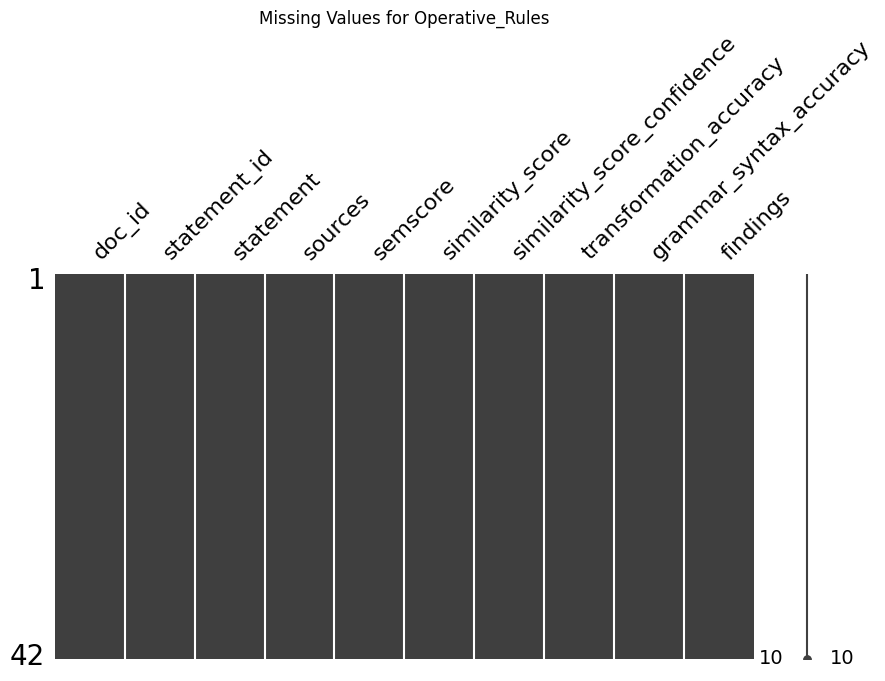

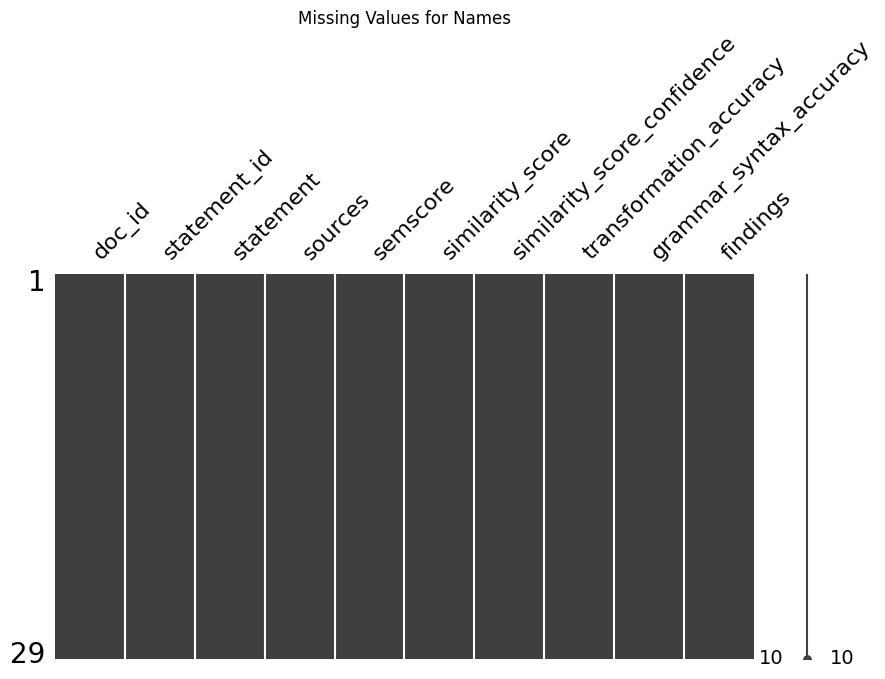

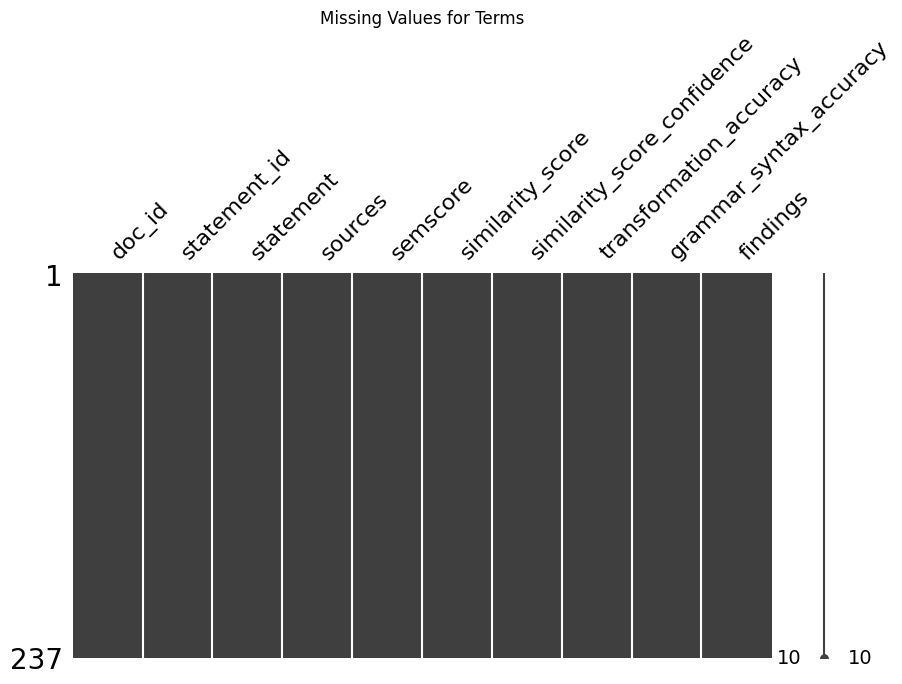

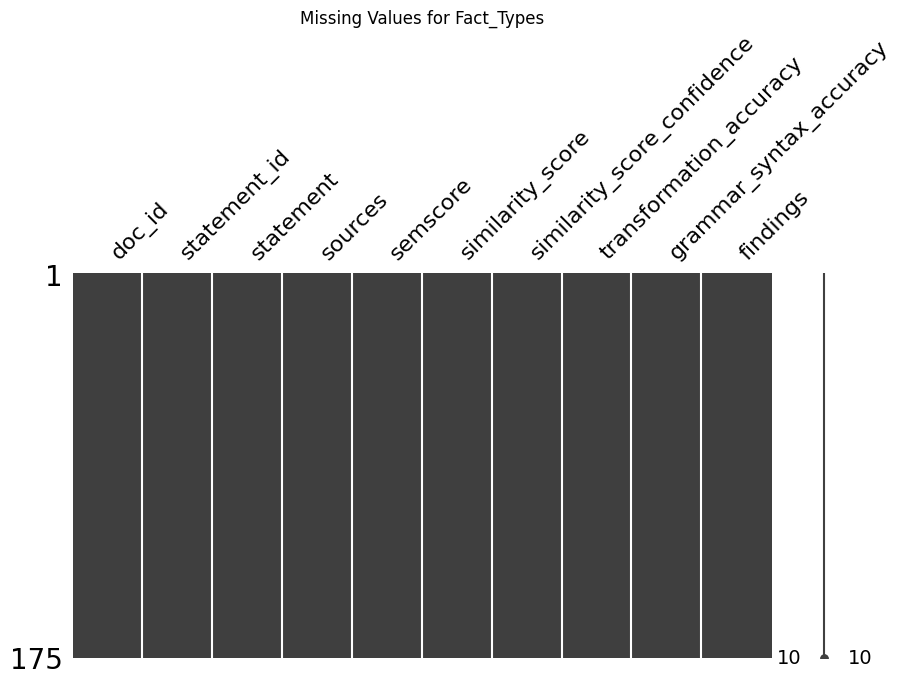

In [43]:
for element_key in elements_data.keys():
    element_df = pd.DataFrame(elements_data[element_key])
    mi.matrix(element_df, figsize=(10, 5))
    plt.title(f"Missing Values for {element_key}")

#### Metrics

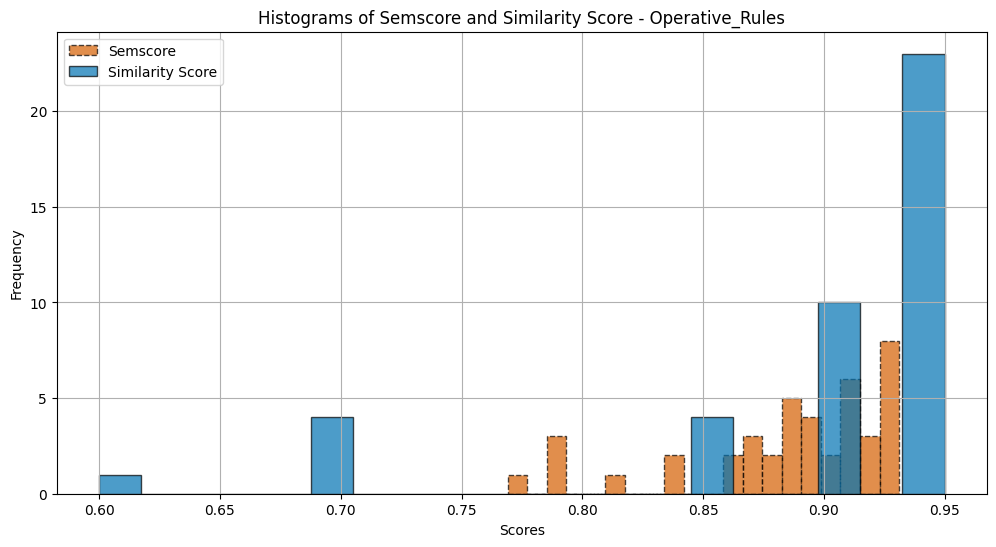

/tmp/ipykernel_80911/1859200400.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


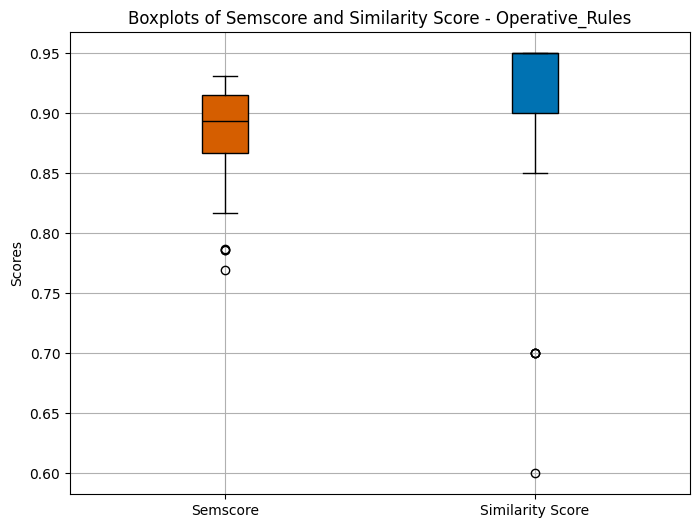

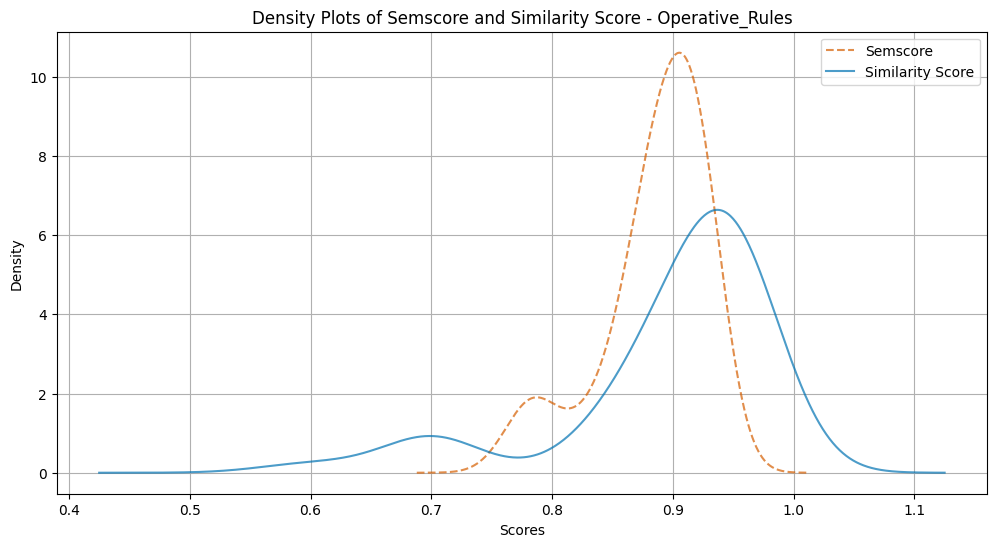

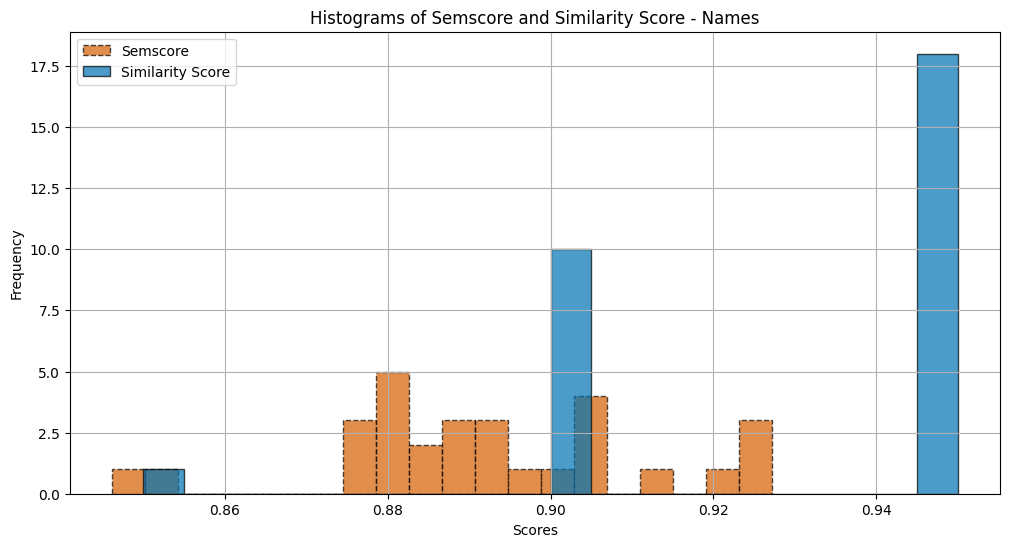

/tmp/ipykernel_80911/1859200400.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


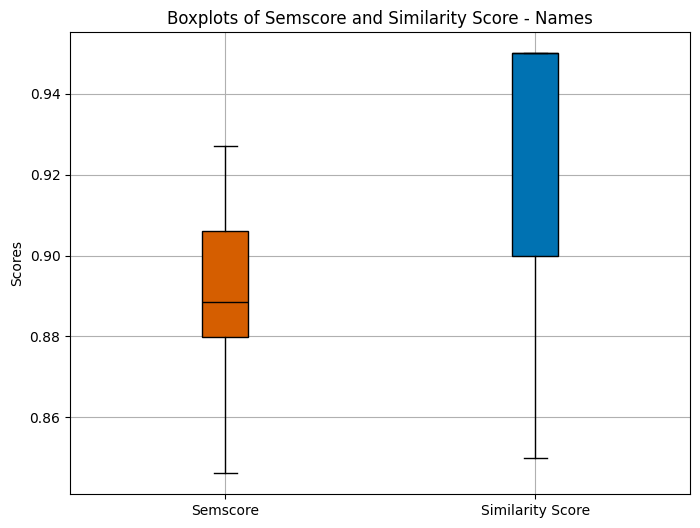

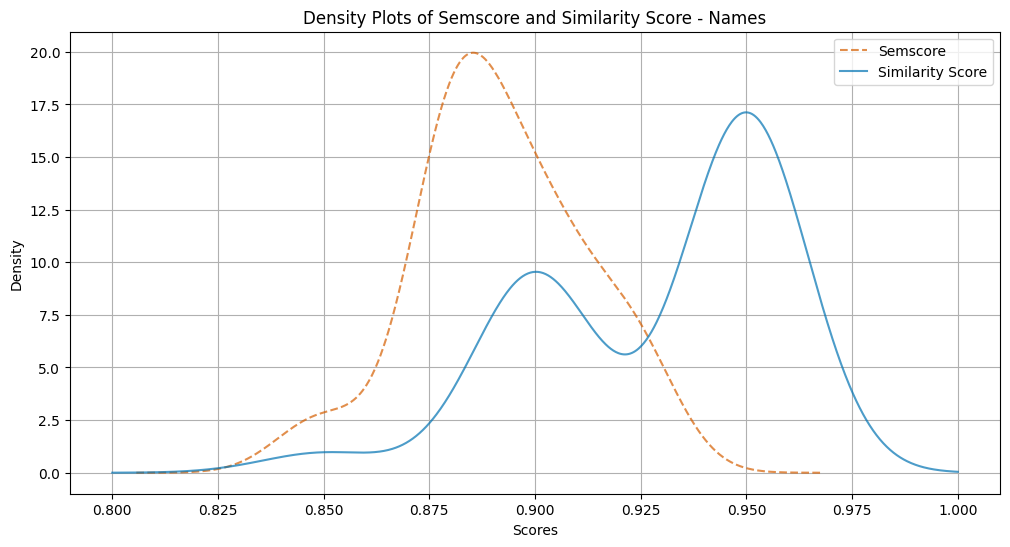

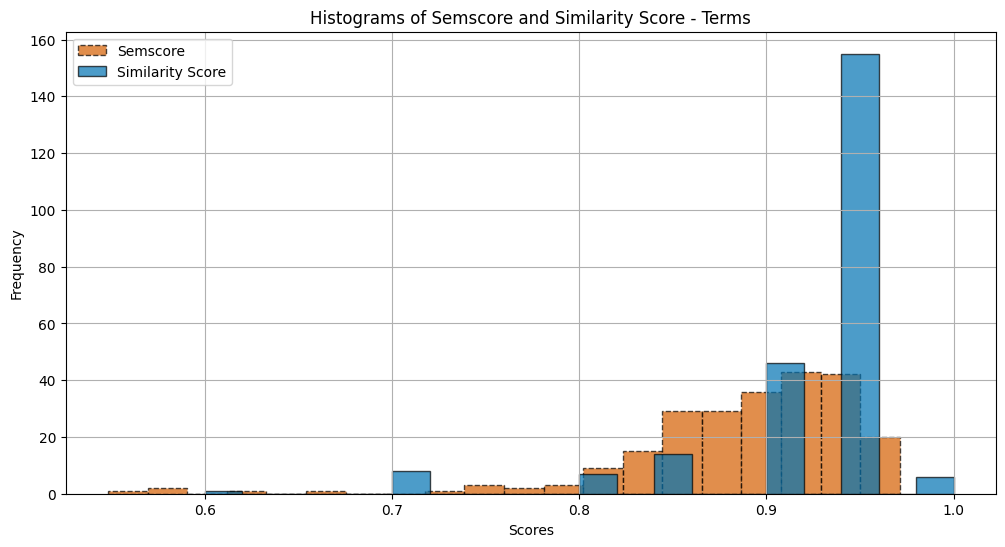

/tmp/ipykernel_80911/1859200400.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


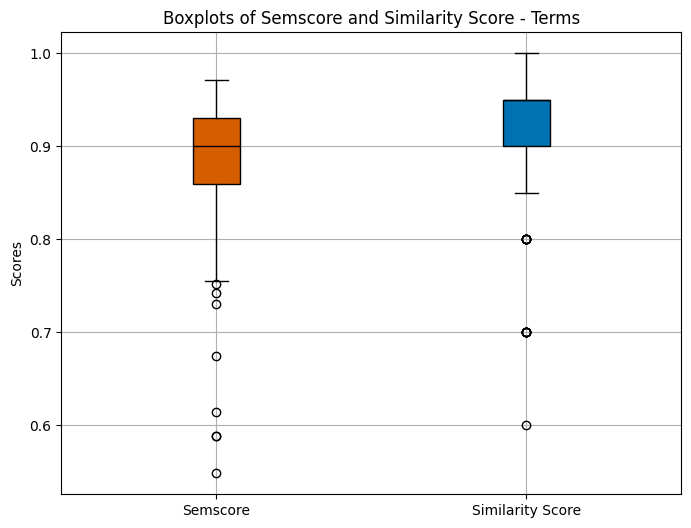

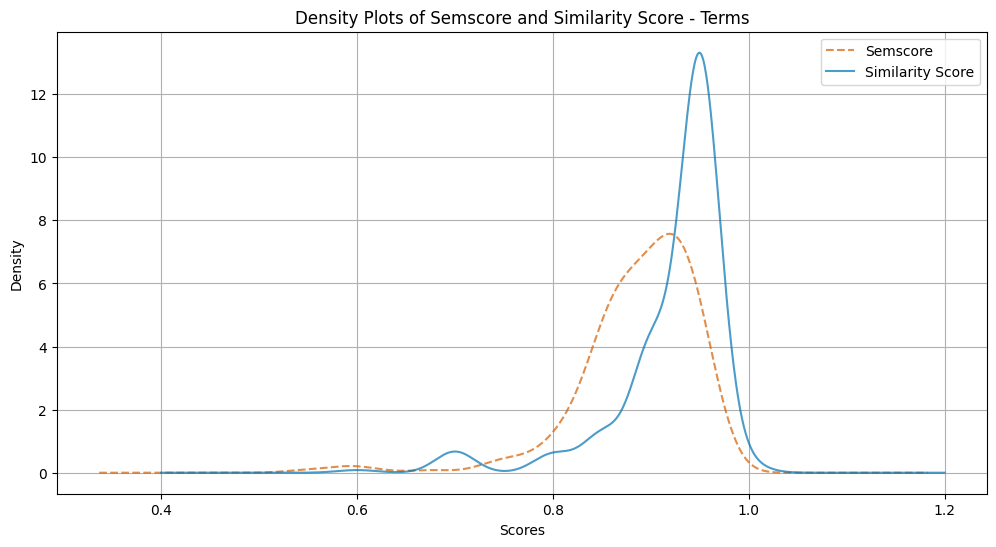

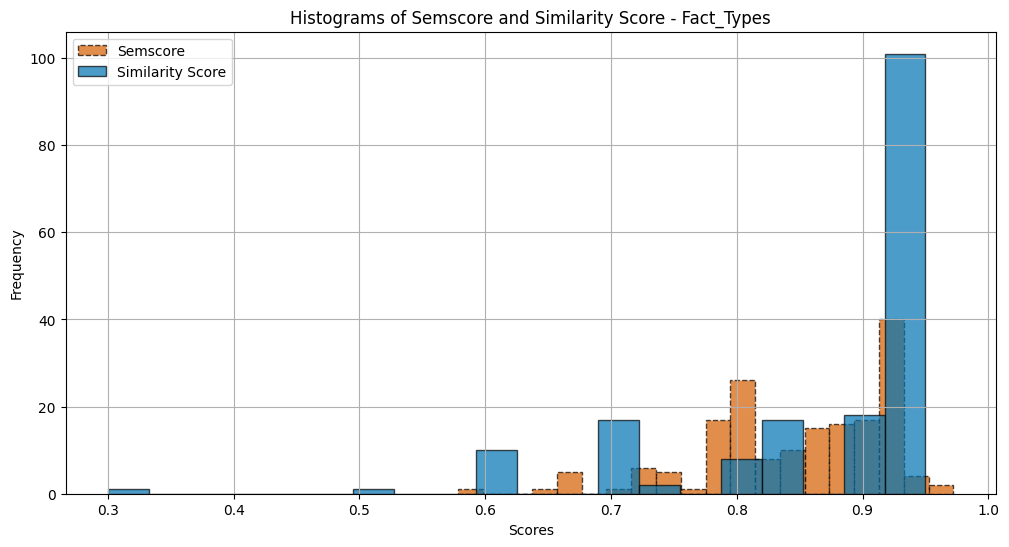

/tmp/ipykernel_80911/1859200400.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


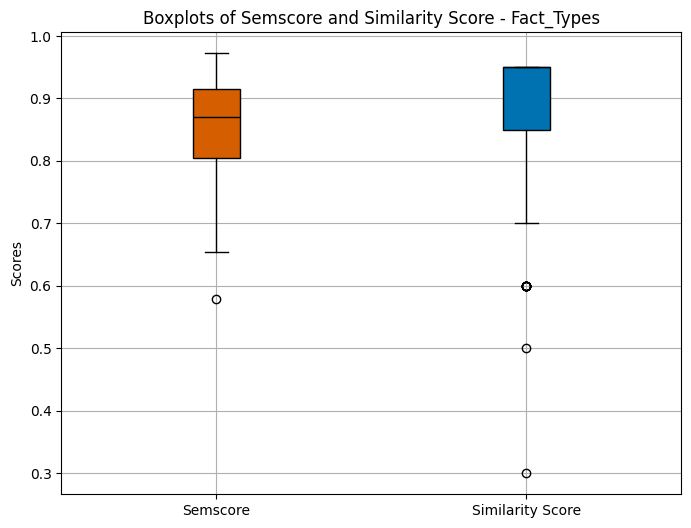

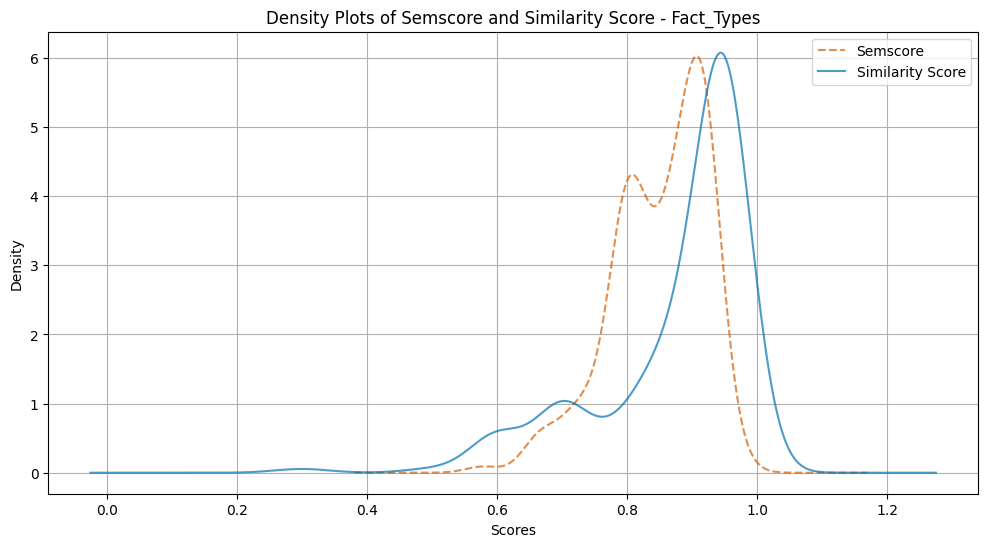

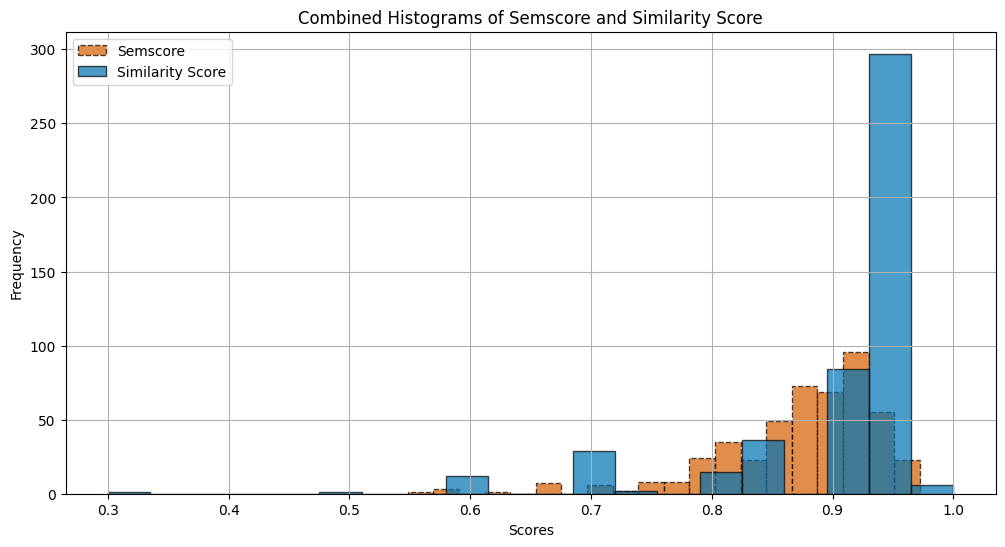

/tmp/ipykernel_80911/1859200400.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


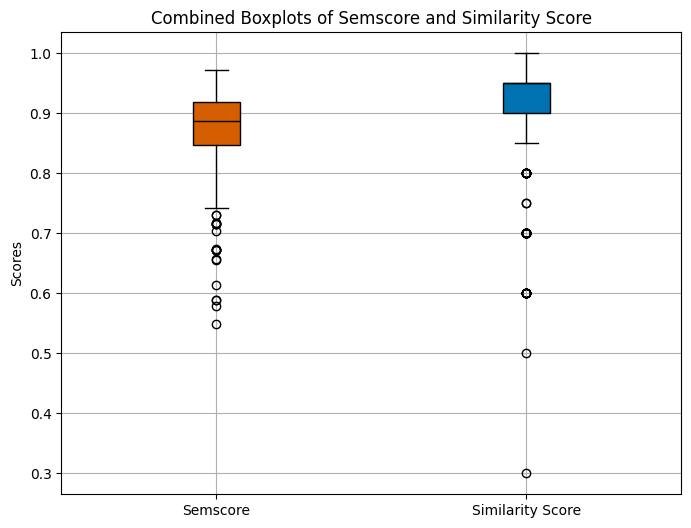

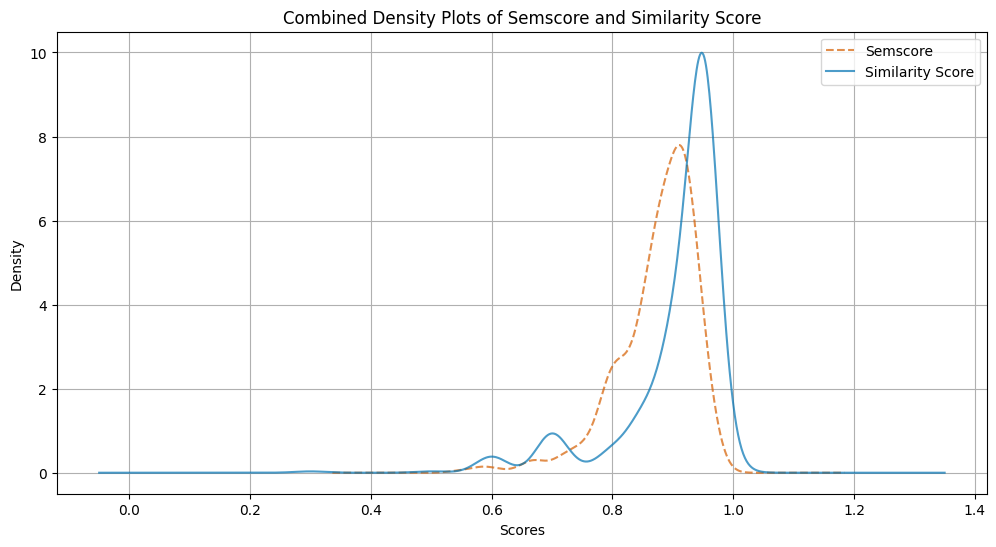

In [44]:
combined_df = process_all_elements_updated(elements_data, config["DEFAULT_OUTPUT_DIR"])

Describing the metrics semscore and similarity_score

In [110]:
filtered_df = combined_df[combined_df["doc_id"] == "§ 275.0-2"]
filtered_df[["semscore", "similarity_score"]].describe()#.to_excel(config["DEFAULT_OUTPUT_DIR"] + "/sem_sim_descriptive_stats.xlsx")

semscore  similarity_score
count  130.000000        130.000000
mean     0.902264          0.920385
std      0.030185          0.058963
min      0.784661          0.700000
25%      0.883270          0.900000
50%      0.907394          0.950000
75%      0.921280          0.950000
max      0.960378          1.000000

In [58]:
combined_df.groupby("element_type")[["semscore", "similarity_score"]].describe()#.to_excel(config["DEFAULT_OUTPUT_DIR"] + "/sem_sim_descriptive_stats.xlsx")

semscore                                                    \
                   count      mean       std       min       25%       50%   
element_type                                                                 
Fact_Types         160.0  0.875031  0.054416  0.714021  0.821412  0.883450   
Names               50.0  0.885333  0.030958  0.810035  0.883378  0.902060   
Operative_Rules     60.0  0.907990  0.019192  0.873461  0.889514  0.910879   
Terms              280.0  0.848829  0.077379  0.504298  0.829878  0.851205   

                                    similarity_score                      \
                      75%       max            count      mean       std   
element_type                                                               
Fact_Types       0.918956  0.972246            160.0  0.920000  0.056413   
Names            0.904557  0.909534             50.0  0.949000  0.007071   
Operative_Rules  0.922699  0.933172             60.0  0.903333  0.047716   
Terms            0.904896  0.960378            280.0  0.920536  0.051306   

                                               
                  min   25%   50%   75%   max  
element_type                                   
Fact_Types       0.70  0.90  0.95  0.95  0.95  
Names            0.90  0.95  0.95  0.95  0.95  
Operative_Rules  0.75  0.90  0.90  0.95  0.95  
Terms            0.60  0.90  0.95  0.95  1.00

> See correlation analysis below

Similarity_score and confidence

In [101]:
combined_df[["similarity_score", "similarity_score_confidence"]].describe().to_excel(config["DEFAULT_OUTPUT_DIR"] + "/similarity_score_confidence_descriptive_stats.xlsx")
combined_df[["similarity_score", "similarity_score_confidence"]].describe()

similarity_score  similarity_score_confidence
count        550.000000                   550.000000
mean           0.921091                     0.889818
std            0.051132                     0.029661
min            0.600000                     0.700000
25%            0.900000                     0.900000
50%            0.950000                     0.900000
75%            0.950000                     0.900000
max            1.000000                     1.000000

In [59]:
combined_df.groupby("element_type")[["similarity_score", "similarity_score_confidence"]].describe().to_excel(config["DEFAULT_OUTPUT_DIR"] + "/similarity_score_confidence_descriptive_stats.xlsx")
combined_df.groupby("element_type")[["similarity_score", "similarity_score_confidence"]].describe()

similarity_score                                              \
                           count      mean       std   min   25%   50%   75%   
element_type                                                                   
Fact_Types                 160.0  0.920000  0.056413  0.70  0.90  0.95  0.95   
Names                       50.0  0.949000  0.007071  0.90  0.95  0.95  0.95   
Operative_Rules             60.0  0.903333  0.047716  0.75  0.90  0.90  0.95   
Terms                      280.0  0.920536  0.051306  0.60  0.90  0.95  0.95   

                      similarity_score_confidence                           \
                  max                       count      mean       std  min   
element_type                                                                 
Fact_Types       0.95                       160.0  0.891563  0.026435  0.7   
Names            0.95                        50.0  0.901000  0.007071  0.9   
Operative_Rules  0.95                        60.0  0.879167  0.029533  0.8   
Terms            1.00                       280.0  0.889107  0.033024  0.8   

                                       
                  25%  50%  75%   max  
element_type                           
Fact_Types       0.90  0.9  0.9  0.90  
Names            0.90  0.9  0.9  0.95  
Operative_Rules  0.85  0.9  0.9  0.90  
Terms            0.85  0.9  0.9  1.00

Instance above 75%

In [100]:
# Suppose we have a DataFrame named 'combined_df' 
# with 'element_type' and 'similarity_score' columns
stats_75 = combined_df.groupby("element_type")["similarity_score"].quantile(0.75)

combined_df.groupby("element_type").apply(
    lambda grp: (grp["similarity_score"] >= stats_75[grp.name]).sum()
)

/tmp/ipykernel_23509/2099162738.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



element_type
Fact_Types         114
Names               49
Operative_Rules     20
Terms              162
dtype: int64

In [61]:
# Calculate correlation by element_type
combined_df.groupby("element_type").apply(
    lambda group: group["similarity_score"].corr(group["similarity_score_confidence"])
).reset_index(name="correlation")

/tmp/ipykernel_23509/3731941340.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df.groupby("element_type").apply(


element_type  correlation
0       Fact_Types     0.598877
1            Names    -1.000000
2  Operative_Rules     0.591359
3            Terms     0.555577

transformation_accuracy and grammar_syntax_accuracy

In [62]:
combined_df.groupby("element_type")[["transformation_accuracy", "grammar_syntax_accuracy"]].describe().to_excel(config["DEFAULT_OUTPUT_DIR"] + "/transformation_accuracy_grammar_descriptive_stats.xlsx")
combined_df.groupby("element_type")[["transformation_accuracy", "grammar_syntax_accuracy"]].describe()

transformation_accuracy                                        \
                                  count      mean       std   min   25%   50%   
element_type                                                                    
Fact_Types                        160.0  0.866875  0.089000  0.50  0.85  0.90   
Names                              50.0  0.919000  0.026515  0.85  0.90  0.90   
Operative_Rules                    60.0  0.840000  0.073531  0.70  0.80  0.85   
Terms                             280.0  0.879464  0.080086  0.50  0.80  0.90   

                            grammar_syntax_accuracy                            \
                  75%   max                   count      mean       std   min   
element_type                                                                    
Fact_Types       0.90  0.95                   160.0  0.931250  0.088622  0.50   
Names            0.95  0.95                    50.0  0.970000  0.024744  0.95   
Operative_Rules  0.90  0.90                    60.0  0.927500  0.054792  0.70   
Terms            0.95  1.00                   280.0  0.954821  0.064090  0.40   

                                         
                  25%   50%   75%   max  
element_type                             
Fact_Types       0.95  0.95  0.95  1.00  
Names            0.95  0.95  1.00  1.00  
Operative_Rules  0.95  0.95  0.95  0.95  
Terms            0.95  0.95  1.00  1.00

In [63]:
# Calculate correlation by element_type
combined_df.groupby("element_type").apply(
    lambda group: group["transformation_accuracy"].corr(group["grammar_syntax_accuracy"])
).reset_index(name="correlation")

/tmp/ipykernel_23509/1485779397.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df.groupby("element_type").apply(


element_type  correlation
0       Fact_Types     0.680278
1            Names     0.808757
2  Operative_Rules     0.689936
3            Terms     0.736881

#### Correlation analysis similarity_score and semscore

Top 10 lowest semscore

In [64]:
# Make a copy of the DataFrame for further analysis
df_aval = combined_df.copy()

df_similarity = combined_df.copy()

df_agree = combined_df.copy()

Top 10 lowest semscore and similarity_score

In [65]:
df_aval.nsmallest(15, ["similarity_score"])

doc_id             statement_id  \
128  § 275.0-5  Order of the Commission   
296  § 275.0-5  Order of the Commission   
221  § 275.0-7                    Trust   
333  § 275.0-7                    Trust   
422  § 275.0-2                        1   
502  § 275.0-2                        1   
518  § 275.0-2                        1   
534  § 275.0-2                        1   
15   § 275.0-5                        2   
21   § 275.0-5                        2   
45   § 275.0-5                        2   
135  § 275.0-7              Partnership   
137  § 275.0-7                    Trust   
249  § 275.0-7                    Trust   
305  § 275.0-7                    Trust   

                                             statement       sources  \
128   An order issued by the Commission under the Act.         [(d)]   
296   An order issued by the Commission under the Act.         [(d)]   
221  A person is presumed to control a trust if the...  [(b)(1)(iv)]   
333  A person is presumed to control a trust if the...  [(b)(1)(iv)]   
422  A person may serve process, pleadings, or othe...         [(a)]   
502  A person may serve process, pleadings, or othe...         [(a)]   
518  A person may serve process, pleadings, or othe...         [(a)]   
534  A person may serve process, pleadings, or othe...         [(a)]   
15   Any interested person may, within the period o...         [(a)]   
21   Any interested person may, within the period o...         [(a)]   
45   Any interested person may, within the period o...         [(a)]   
135  A person is presumed to control a partnership ...  [(b)(1)(ii)]   
137  A person is presumed to control a trust if the...  [(b)(1)(iv)]   
249  A person is presumed to control a trust if the...  [(b)(1)(iv)]   
305  A person is presumed to control a trust if the...  [(b)(1)(iv)]   

     semscore  similarity_score  similarity_score_confidence  \
128  0.814453              0.60                          0.8   
296  0.814386              0.60                          0.8   
221  0.831078              0.70                          0.8   
333  0.886054              0.70                          0.8   
422  0.915262              0.70                          0.8   
502  0.915322              0.70                          0.8   
518  0.934256              0.70                          0.8   
534  0.934340              0.70                          0.8   
15   0.880738              0.75                          0.8   
21   0.880711              0.75                          0.8   
45   0.880703              0.75                          0.8   
135  0.924652              0.80                          0.9   
137  0.831016              0.80                          0.9   
249  0.831041              0.80                          0.9   
305  0.831010              0.80                          0.9   

     transformation_accuracy  grammar_syntax_accuracy  \
128                      0.5                      0.4   
296                      0.5                      0.4   
221                      0.6                      0.9   
333                      0.6                      0.5   
422                      0.6                      0.9   
502                      0.6                      0.9   
518                      0.5                      0.9   
534                      0.5                      0.9   
15                       0.7                      0.9   
21                       0.7                      0.9   
45                       0.7                      0.9   
135                      0.7                      0.9   
137                      0.7                      0.9   
249                      0.7                      0.9   
305                      0.7                      0.9   

                                              findings     element_type  
128  [The transformed sentence does not accurately ...            Terms  
296  [The transformed sentence does not accurately ...            Terms  
221  [

In [66]:
df_aval.nsmallest(15, ["semscore"])

doc_id             statement_id  \
295  § 275.0-5  Protection of investors   
211  § 275.0-5  Protection of investors   
155  § 275.0-5  Protection of investors   
183  § 275.0-5  Protection of investors   
323  § 275.0-5  Protection of investors   
127  § 275.0-5  Protection of investors   
351  § 275.0-5  Protection of investors   
239  § 275.0-5  Protection of investors   
379  § 275.0-5  Protection of investors   
267  § 275.0-5  Protection of investors   
329  § 275.0-7                  Control   
217  § 275.0-7                  Control   
245  § 275.0-7                  Control   
189  § 275.0-7                  Control   
385  § 275.0-7                  Control   

                                             statement           sources  \
295  A consideration for ordering a hearing if it a...             [(c)]   
211  A consideration for ordering a hearing if it a...             [(c)]   
155  A consideration for ordering a hearing if it a...             [(c)]   
183  A consideration for ordering a hearing if it a...             [(c)]   
323  A consideration for ordering a hearing if it a...             [(c)]   
127  A consideration for ordering a hearing if it a...             [(c)]   
351  A consideration for ordering a hearing if it a...             [(c)]   
239  A consideration for ordering a hearing if it a...             [(c)]   
379  A consideration for ordering a hearing if it a...             [(c)]   
267  A consideration for ordering a hearing if it a...             [(c)]   
329  The power, directly or indirectly, to direct t...  [(b)(1), (a)(3)]   
217  The power, directly or indirectly, to direct t...  [(b)(1), (a)(3)]   
245  The power, directly or indirectly, to direct t...  [(b)(1), (a)(3)]   
189  The power, directly or indirectly, to direct t...  [(a)(3), (b)(1)]   
385  The power, directly or indirectly, to direct t...  [(b)(1), (a)(3)]   

     semscore  similarity_score  similarity_score_confidence  \
295  0.504298              0.85                         0.90   
211  0.534698              0.85                         0.90   
155  0.588489              0.90                         0.85   
183  0.588578              0.90                         0.85   
323  0.588613              0.90                         0.85   
127  0.588633              0.90                         0.85   
351  0.588633              0.90                         0.85   
239  0.588672              0.90                         0.85   
379  0.588672              0.90                         0.85   
267  0.589421              0.90                         0.85   
329  0.685248              0.90                         0.85   
217  0.711167              0.85                         0.90   
245  0.712439              0.85                         0.90   
189  0.712491              0.85                         0.90   
385  0.713834              0.90                         0.85   

     transformation_accuracy  grammar_syntax_accuracy  \
295                      0.8                     0.95   
211                      0.8                     0.95   
155                      0.9                     0.95   
183                      0.9                     0.95   
323                      0.9                     0.95   
127                      0.9                     0.95   
351                      0.9                     0.95   
239                      0.9                     0.95   
379                      0.9                     0.95   
267                      0.9                     0.95   
329                      0.8                     0.95   
217                      0.8                     0.95   
245                      0.8                     0.95   
189                      0.8                     0.95   
385                      0.8                     0.95   

                                              findings element_type  
295  [The transformed sentence accurately reflects ...        Terms  
211  [The transformed se

In [67]:
df_aval.nsmallest(15, ["grammar_syntax_accuracy"])

doc_id             statement_id  \
128  § 275.0-5  Order of the Commission   
296  § 275.0-5  Order of the Commission   
333  § 275.0-7                    Trust   
420  § 275.0-7                        9   
390  § 275.0-2                        1   
404  § 275.0-7                        9   
468  § 275.0-7                        9   
470  § 275.0-2                        1   
516  § 275.0-7                        9   
532  § 275.0-7                        9   
548  § 275.0-7                        9   
16   § 275.0-5                        3   
4    § 275.0-5                        3   
10   § 275.0-5                        3   
28   § 275.0-5                        3   

                                             statement       sources  \
128   An order issued by the Commission under the Act.         [(d)]   
296   An order issued by the Commission under the Act.         [(d)]   
333  A person is presumed to control a trust if the...  [(b)(1)(iv)]   
420  A person is presumed to control a trust if the...  [(b)(1)(iv)]   
390  A person may serve process, pleadings, or othe...         [(a)]   
404  A person is presumed to control a trust if the...  [(b)(1)(iv)]   
468  A person is presumed to control a trust if the...  [(b)(1)(iv)]   
470  A person may serve process, pleadings, or othe...         [(a)]   
516  A person is presumed to control a trust if the...  [(b)(1)(iv)]   
532  A person is presumed to control a trust if the...  [(b)(1)(iv)]   
548  A person is presumed to control a trust if the...  [(b)(1)(iv)]   
16   An order disposing of the matter will be issue...         [(b)]   
4    An order disposing of the matter will be issue...         [(b)]   
10   An order disposing of the matter will be issue...         [(b)]   
28   An order disposing of the matter will be issue...         [(b)]   

     semscore  similarity_score  similarity_score_confidence  \
128  0.814453              0.60                         0.80   
296  0.814386              0.60                         0.80   
333  0.886054              0.70                         0.80   
420  0.773248              0.80                         0.70   
390  0.929842              0.80                         0.90   
404  0.820486              0.80                         0.90   
468  0.821409              0.85                         0.90   
470  0.929930              0.80                         0.90   
516  0.821193              0.80                         0.90   
532  0.773195              0.80                         0.85   
548  0.821413              0.80                         0.90   
16   0.933084              0.90                         0.85   
4    0.933155              0.90                         0.85   
10   0.933130              0.90                         0.85   
28   0.933112              0.90                         0.85   

     transformation_accuracy  grammar_syntax_accuracy  \
128                      0.5                      0.4   
296                      0.5                      0.4   
333                      0.6                      0.5   
420                      0.6                      0.5   
390                      0.7                      0.6   
404                      0.7                      0.6   
468                      0.7                      0.6   
470                      0.7                      0.6   
516                      0.7                      0.6   
532                      0.7                      0.6   
548                      0.7                      0.6   
16                       0.8                      0.7   
4                        0.7                      0.8   
10                       0.7                      0.8   
28                       0.7                      0.8   

                                              findings     element_type  
128  [The transformed sentence does not accurately ...            Terms  
296  [The transformed sentence does not accurately ...            Terms  
333  [

Filter dataframe to study an instance

In [68]:
column = "statement_id"
value = "Order of the Commission"
df_aval[df_aval[column] == value]

doc_id             statement_id  \
128  § 275.0-5  Order of the Commission   
156  § 275.0-5  Order of the Commission   
184  § 275.0-5  Order of the Commission   
212  § 275.0-5  Order of the Commission   
240  § 275.0-5  Order of the Commission   
268  § 275.0-5  Order of the Commission   
296  § 275.0-5  Order of the Commission   
324  § 275.0-5  Order of the Commission   
352  § 275.0-5  Order of the Commission   
380  § 275.0-5  Order of the Commission   

                                            statement sources  semscore  \
128  An order issued by the Commission under the Act.   [(d)]  0.814453   
156  An order issued by the Commission under the Act.   [(d)]  0.848829   
184  An order issued by the Commission under the Act.   [(d)]  0.851817   
212  An order issued by the Commission under the Act.   [(d)]  0.851844   
240  An order issued by the Commission under the Act.   [(d)]  0.848882   
268  An order issued by the Commission under the Act.   [(d)]  0.848876   
296  An order issued by the Commission under the Act.   [(d)]  0.814386   
324  An order issued by the Commission under the Act.   [(d)]  0.848838   
352  An order issued by the Commission under the Act.   [(d)]  0.851824   
380  An order issued by the Commission under the Act.   [(d)]  0.848890   

     similarity_score  similarity_score_confidence  transformation_accuracy  \
128               0.6                         0.80                     0.50   
156               0.9                         0.85                     0.80   
184               0.9                         0.85                     0.80   
212               0.9                         0.85                     0.80   
240               0.9                         0.95                     0.80   
268               0.9                         0.95                     0.85   
296               0.6                         0.80                     0.50   
324               0.9                         0.90                     0.80   
352               0.9                         0.85                     0.80   
380               0.9                         0.85                     0.80   

     grammar_syntax_accuracy  \
128                     0.40   
156                     0.90   
184                     0.95   
212                     0.95   
240                     0.90   
268                     0.90   
296                     0.40   
324                     0.90   
352                     0.90   
380                     0.90   

                                              findings element_type  
128  [The transformed sentence does not accurately ...        Terms  
156  [The transformed sentence maintains the core m...        Terms  
184  [The transformed sentence maintains the core m...        Terms  
212  [The transformed sentence maintains the core m...        Terms  
240  [The transformed sentence maintains the core m...        Terms  
268  [The transformed sentence maintains the core m...        Terms  
296  [The transformed sentence does not accurately ...        Terms  
324  [The transformed sentence maintains the core m...        Terms  
352  [The transformed sentence maintains the core m...        Terms  
380  [The transformed sentence maintains the core m...        Terms

In [69]:
# Convert the 'sources' column to a string type to allow dropping duplicates
df_aval["sources"] = df_aval["sources"].apply(str)

# Filter the distinct records based on doc_id, statement_id, statement, and sources
df_aval.drop_duplicates(subset=["doc_id", "statement_id", "statement", "sources"]).nsmallest(15, ["semscore"])

doc_id                   statement_id  \
127  § 275.0-5        Protection of investors   
115  § 275.0-5                         Notice   
130  § 275.0-7                 Small business   
114  § 275.0-5  Order disposing of the matter   
142  § 275.0-5  Order disposing of the matter   
398  § 275.0-7                              3   
400  § 275.0-7                              5   
131  § 275.0-7             Small organization   
395  § 275.0-5                              5   
128  § 275.0-5        Order of the Commission   
404  § 275.0-7                              9   
123  § 275.0-5                        Reasons   
137  § 275.0-7                          Trust   
68   § 275.0-5                     Commission   
63   § 275.0-5                     Commission   

                                             statement  \
127  A consideration for ordering a hearing if it a...   
115  A publication in the Federal Register indicati...   
130  An investment adviser with assets under manage...   
114  An order issued after the period of time for s...   
142  An order issued after the period of time for s...   
398  An investment adviser did not have total asset...   
400  Control means the power, directly or indirectl...   
131  An investment adviser with assets under manage...   
395  For purposes of this rule, an application mean...   
128   An order issued by the Commission under the Act.   
404  A person is presumed to control a trust if the...   
123  The justification provided by an interested pe...   
137  A person is presumed to control a trust if the...   
68   The regulatory body responsible for issuing or...   
63   The regulatory body responsible for issuing or...   

                          sources  semscore  similarity_score  \
127                       ['(c)']  0.588633              0.90   
115                       ['(a)']  0.764826              0.95   
130                       ['(a)']  0.766613              0.85   
114                ['(b)', '(a)']  0.774899              0.90   
142                ['(a)', '(b)']  0.775006              0.90   
398                    ['(a)(2)']  0.792303              0.95   
400                    ['(b)(1)']  0.795561              0.90   
131                       ['(a)']  0.810215              0.85   
395                       ['(d)']  0.812092              0.95   
128                       ['(d)']  0.814453              0.60   
404                ['(b)(1)(iv)']  0.820486              0.80   
123                       ['(a)']  0.830164              0.95   
137                ['(b)(1)(iv)']  0.831016              0.80   
68   ['(a)', '(d)', '(c)', '(b)']  0.831349              0.95   
63   ['(b)', '(d)', '(a)', '(c)']  0.831410              0.95   

     similarity_score_confidence  transformation_accuracy  \
127                         0.85                     0.90   
115                         0.90                     0.95   
130                         0.90                     0.80   
114                         0.85                     0.80   
142                         0.85                     0.80   
398                         0.90                     0.90   
400                         0.85                     0.90   
131                         0.90                     0.80   
395                         0.90                     0.90   
128                         0.80                     0.50   
404                         0.90                     0.70   
123                         0.90                     0.90   
137                         0.90                     0.70   
68                          0.90                     0.95   
63                          0.90                     0.95   

     grammar_syntax_accuracy  \
127                     0.95   
115                     1.00   
130                     0.95   
114                     0.95   
142                     0.95   
398                     1.00   
400                     0.95   
131                 

In [70]:
df_similarity['score_difference'] = df_similarity['similarity_score'] - df_similarity['semscore']

In [71]:
df_similarity

doc_id statement_id  \
0    § 275.0-2            3   
1    § 275.0-2            4   
2    § 275.0-5            1   
3    § 275.0-5            2   
4    § 275.0-5            3   
..         ...          ...   
545  § 275.0-7            6   
546  § 275.0-7            7   
547  § 275.0-7            8   
548  § 275.0-7            9   
549  § 275.0-7           10   

                                             statement         sources  \
0    The Secretary of the Commission (Secretary) wi...        [(a)(2)]   
1    If the Secretary certifies that the Commission...        [(a)(3)]   
2    Notice of the initiation of the proceeding wil...           [(a)]   
3    Any interested person may, within the period o...           [(a)]   
4    An order disposing of the matter will be issue...           [(b)]   
..                                                 ...             ...   
545  A person is presumed to control a corporation ...  [(b)(1)(i)(A)]   
546  A person is presumed to control a partnership ...    [(b)(1)(ii)]   
547  A person is presumed to control a limited liab...   [(b)(1)(iii)]   
548  A person is presumed to control a trust if the...    [(b)(1)(iv)]   
549  Total assets means the total assets as shown o...        [(b)(2)]   

     semscore  similarity_score  similarity_score_confidence  \
0    0.907310              0.90                         0.90   
1    0.922476              0.90                         0.85   
2    0.889516              0.95                         0.90   
3    0.881079              0.85                         0.90   
4    0.933155              0.90                         0.85   
..        ...               ...                          ...   
545  0.732264              0.85                         0.90   
546  0.889638              0.95                         0.90   
547  0.940801              0.95                         0.90   
548  0.821413              0.80                         0.90   
549  0.920697              0.95                         0.90   

     transformation_accuracy  grammar_syntax_accuracy  \
0                       0.85                     0.95   
1                       0.90                     0.95   
2                       0.90                     0.95   
3                       0.80                     0.95   
4                       0.70                     0.80   
..                       ...                      ...   
545                     0.80                     0.95   
546                     0.90                     0.95   
547                     0.90                     0.95   
548                     0.70                     0.60   
549                     0.90                     0.95   

                                              findings     element_type  \
0    [The transformed sentence maintains the core m...  Operative_Rules   
1    [The transformed sentence maintains the origin...  Operative_Rules   
2    [The transformed sentence maintains the origin...  Operative_Rules   
3    [The transformed sentence captures the essence...  Operative_Rules   
4    [The transformed sentence uses 'may be issued'...  Operative_Rules   
..                                                 ...              ...   
545  [The transformed sentence maintains the core m...       Fact_Types   
546  [The transformed sentence maintains the origin...       Fact_Types   
547  [The transformed sentence maintains the origin...       Fact_Types   
548  [The transformed sentence introduces 'by defin...       Fact_Types   
549  [The transformed sentence closely follows the ...       Fact_Types   

     score_difference  
0           -0.007310  
1           -0.022476  
2            0.060484  
3           -0.031079  
4           -0.033155  
..                ...  
545          0.117736  
546          0.060362  
547          0.009199  
548         -0.021413  
549          0.029303  

[550 rows x 12 columns]

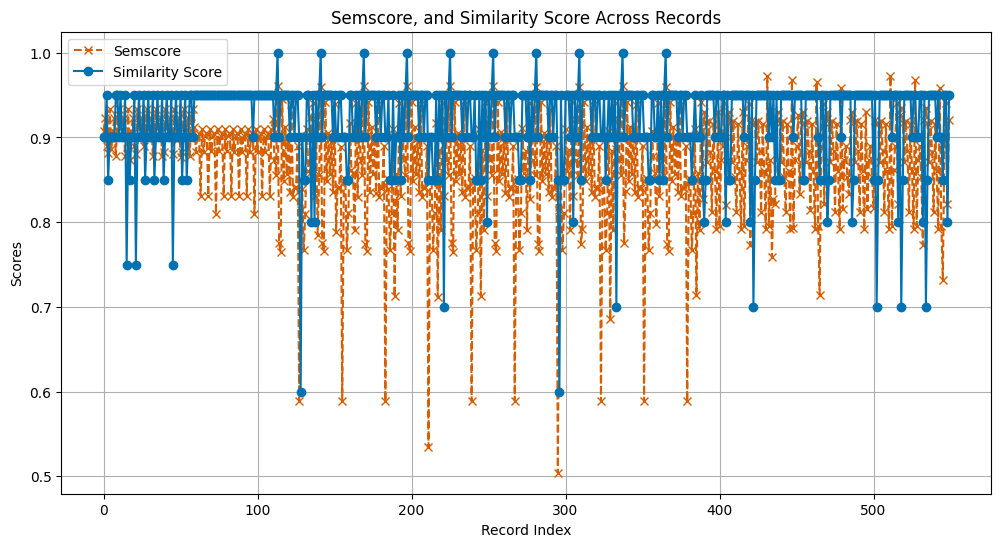

In [72]:
# Plot the semscore, similarity score, and score difference on the same graph
plt.figure(figsize=(12, 6))

plt.plot(df_similarity.index, df_similarity['semscore'], color='#D55E00', marker='x', linestyle='--', label='Semscore')
plt.plot(df_similarity.index, df_similarity['similarity_score'], color='#0072B2', marker='o', linestyle='-', label='Similarity Score')

plt.title('Semscore, and Similarity Score Across Records')
plt.xlabel('Record Index')
plt.ylabel('Scores')
plt.grid(True)
plt.legend()
plt.show()

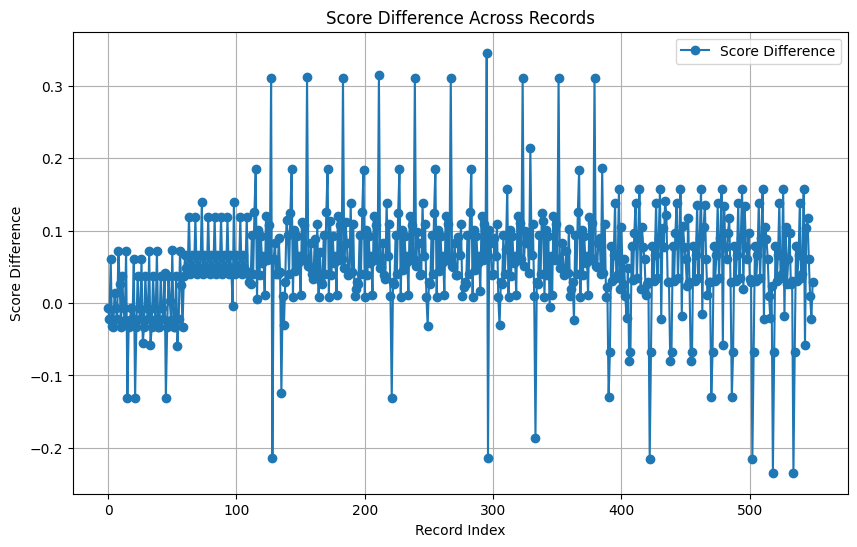

In [73]:
# Plot the score difference as a line chart
plt.figure(figsize=(10, 6))
plt.plot(df_similarity.index, df_similarity['score_difference'], marker='o', linestyle='-', label='Score Difference')
plt.title('Score Difference Across Records')
plt.xlabel('Record Index')
plt.ylabel('Score Difference')
plt.grid(True)
plt.legend()
plt.show()


In [74]:
# Create an interactive scatter plot
fig = go.Figure()

marker_map = {
    'Operative_Rules': 'circle',
    'Names': 'x',
    'Terms': 'triangle-up',
    'Fact_Types': 'diamond'
}

# Add a trace for each element_type
unique_types = df_similarity['element_type'].unique()
for etype in unique_types:
    filtered_data = df_similarity[df_similarity['element_type'] == etype]
    fig.add_trace(go.Scatter(
        x=filtered_data.index,
        y=filtered_data['score_difference'],
        mode='lines+markers',
        marker=dict(symbol=marker_map[etype]),  # Wrap the symbol in a dictionary
        name=etype,
        visible=True  # Ensure all traces are visible initially
    ))

# Add dropdown to filter by element_type
dropdown_buttons = [
    dict(label="All",
         method="update",
         args=[{"visible": [True] * len(unique_types)},  # Show all traces
               {"title": "Score Difference - All Element Types"}]),
]

for i, etype in enumerate(unique_types):
    dropdown_buttons.append(
        dict(label=etype,
             method="update",
             args=[{"visible": [j == i for j in range(len(unique_types))]},  # Show only the selected trace
                   {"title": f"Score Difference - {etype}"}])
    )

fig.update_layout(
    updatemenus=[
        dict(
            buttons=dropdown_buttons,
            direction="down",
            showactive=True,
            x=0.1,
            y=1.15
        )
    ],
    title="Score Difference Across Element Types",
    xaxis_title="Record Index",
    yaxis_title="Score Difference",
    showlegend=True
)

fig.show()



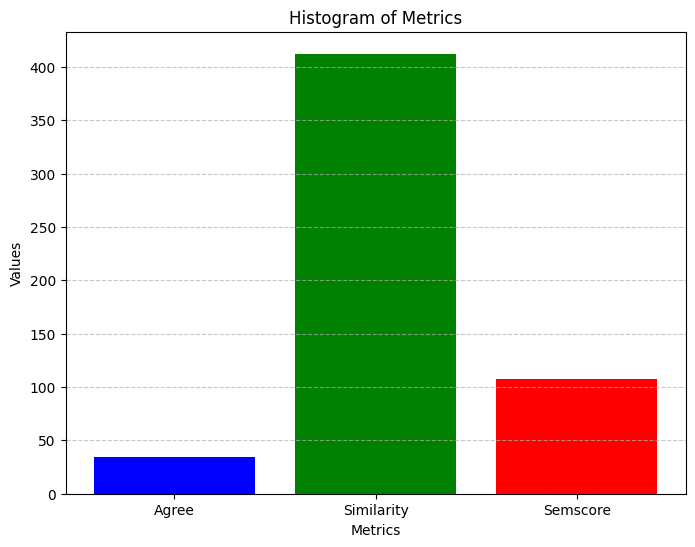

In [75]:
df_agree['score_difference'] = df_agree['similarity_score'] - df_agree['semscore']

# Calculate the required values
agree = ((df_agree['score_difference'] >= -0.01) & (df_agree['score_difference'] <= 0.01)).sum()
similarity = (1 - df_agree.loc[df_agree['score_difference'] > 0.01, 'score_difference']).sum()
semscore = (1 - df_agree.loc[df_agree['score_difference'] < 0.01, 'score_difference']).sum()

# Create a new DataFrame with the calculated values
summary_df = pd.DataFrame({
    'Metric': ['Agree', 'Similarity', 'Semscore'],
    'Value': [agree, similarity, semscore]
})

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(summary_df['Metric'], summary_df['Value'], color=['blue', 'green', 'red'])
plt.title('Histogram of Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [76]:
# Display the calculated values
summary_df["Percentage"] = (summary_df["Value"] / summary_df["Value"].sum()) * 100
summary_df

Metric       Value  Percentage
0       Agree   34.000000    6.139144
1  Similarity  412.242183   74.435705
2    Semscore  107.580991   19.425152

In [77]:
df_aval.nsmallest(15, ["semscore"])

doc_id             statement_id  \
295  § 275.0-5  Protection of investors   
211  § 275.0-5  Protection of investors   
155  § 275.0-5  Protection of investors   
183  § 275.0-5  Protection of investors   
323  § 275.0-5  Protection of investors   
127  § 275.0-5  Protection of investors   
351  § 275.0-5  Protection of investors   
239  § 275.0-5  Protection of investors   
379  § 275.0-5  Protection of investors   
267  § 275.0-5  Protection of investors   
329  § 275.0-7                  Control   
217  § 275.0-7                  Control   
245  § 275.0-7                  Control   
189  § 275.0-7                  Control   
385  § 275.0-7                  Control   

                                             statement               sources  \
295  A consideration for ordering a hearing if it a...               ['(c)']   
211  A consideration for ordering a hearing if it a...               ['(c)']   
155  A consideration for ordering a hearing if it a...               ['(c)']   
183  A consideration for ordering a hearing if it a...               ['(c)']   
323  A consideration for ordering a hearing if it a...               ['(c)']   
127  A consideration for ordering a hearing if it a...               ['(c)']   
351  A consideration for ordering a hearing if it a...               ['(c)']   
239  A consideration for ordering a hearing if it a...               ['(c)']   
379  A consideration for ordering a hearing if it a...               ['(c)']   
267  A consideration for ordering a hearing if it a...               ['(c)']   
329  The power, directly or indirectly, to direct t...  ['(b)(1)', '(a)(3)']   
217  The power, directly or indirectly, to direct t...  ['(b)(1)', '(a)(3)']   
245  The power, directly or indirectly, to direct t...  ['(b)(1)', '(a)(3)']   
189  The power, directly or indirectly, to direct t...  ['(a)(3)', '(b)(1)']   
385  The power, directly or indirectly, to direct t...  ['(b)(1)', '(a)(3)']   

     semscore  similarity_score  similarity_score_confidence  \
295  0.504298              0.85                         0.90   
211  0.534698              0.85                         0.90   
155  0.588489              0.90                         0.85   
183  0.588578              0.90                         0.85   
323  0.588613              0.90                         0.85   
127  0.588633              0.90                         0.85   
351  0.588633              0.90                         0.85   
239  0.588672              0.90                         0.85   
379  0.588672              0.90                         0.85   
267  0.589421              0.90                         0.85   
329  0.685248              0.90                         0.85   
217  0.711167              0.85                         0.90   
245  0.712439              0.85                         0.90   
189  0.712491              0.85                         0.90   
385  0.713834              0.90                         0.85   

     transformation_accuracy  grammar_syntax_accuracy  \
295                      0.8                     0.95   
211                      0.8                     0.95   
155                      0.9                     0.95   
183                      0.9                     0.95   
323                      0.9                     0.95   
127                      0.9                     0.95   
351                      0.9                     0.95   
239                      0.9                     0.95   
379                      0.9                     0.95   
267                      0.9                     0.95   
329                      0.8                     0.95   
217                      0.8                     0.95   
245                      0.8                     0.95   
189                      0.8                     0.95   
385                      0.8                     0.95   

                                              findings element_type  
295  [The transformed sentence

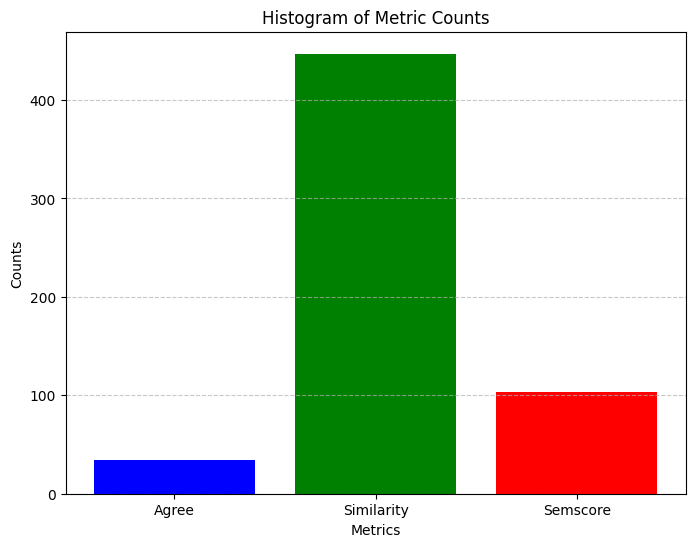

In [78]:
# Count the occurrences for each metric
agree_count = ((df_agree['score_difference'] >= -0.01) & (df_agree['score_difference'] <= 0.01)).sum()
similarity_count = (df_agree['score_difference'] > 0.01).sum()
semscore_count = (df_agree['score_difference'] < 0.01).sum()

# Create a new DataFrame with the counts
count_summary_df = pd.DataFrame({
    'Metric': ['Agree', 'Similarity', 'Semscore'],
    'Count': [agree_count, similarity_count, semscore_count]
})

# Plot the histogram for counts
plt.figure(figsize=(8, 6))
plt.bar(count_summary_df['Metric'], count_summary_df['Count'], color=['blue', 'green', 'red'])
plt.title('Histogram of Metric Counts')
plt.xlabel('Metrics')
plt.ylabel('Counts')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [79]:
# Display the calculated counts
count_summary_df["Percentage"] = (count_summary_df["Count"] / count_summary_df["Count"].sum()) * 100

count_summary_df

Metric  Count  Percentage
0       Agree     34    5.821918
1  Similarity    447   76.541096
2    Semscore    103   17.636986

In [80]:
# Define the 10% margin
margin = 0.1

# Compute agreement within the +/-10% margin
agreement_margin = ((df_agree['similarity_score'] >= (df_agree['semscore'] - margin)) &
                    (df_agree['similarity_score'] <= (df_agree['semscore'] + margin))).sum()

# Compute disagreement outside the +/-10% margin
disagreement_margin = len(df_agree) - agreement_margin

# Display the results
agreement_disagreement_summary = pd.DataFrame({
    'Metric': ['Agreement', 'Disagreement'],
    'Count': [agreement_margin, disagreement_margin]
})

In [81]:
agreement_disagreement_summary["Percentage"] = (agreement_disagreement_summary["Count"] / agreement_disagreement_summary["Count"].sum()) * 100
agreement_disagreement_summary

Metric  Count  Percentage
0     Agreement    412   74.909091
1  Disagreement    138   25.090909

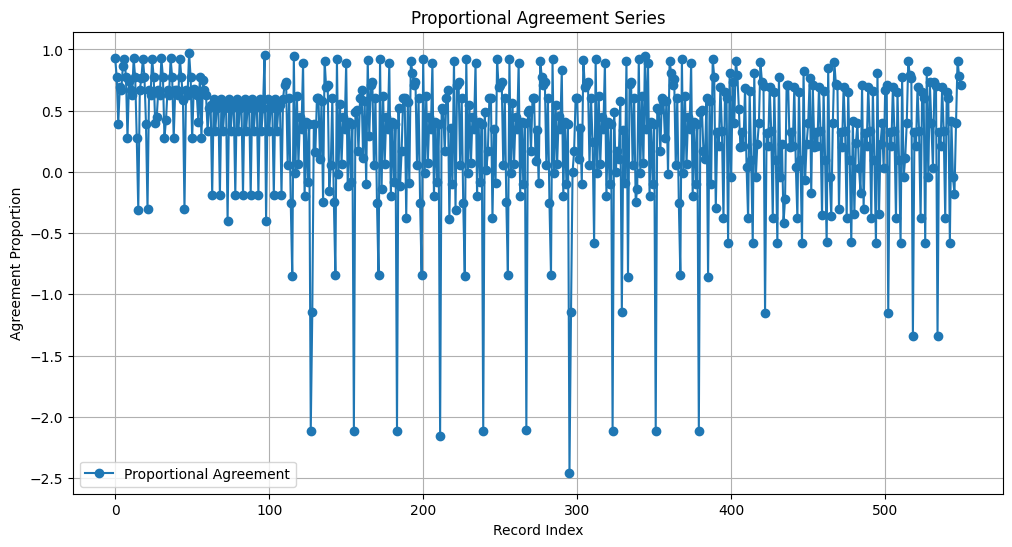

In [82]:
# Compute proportional agreement within the ±10% margin
df_agree['agreement_proportion'] = 1 - (df_agree['similarity_score'] - df_agree['semscore']).abs() / margin
#df_agree['agreement_proportion'] = df_agree['agreement_proportion'].clip(lower=0)  # Clip negative values to 0

# Plot the proportional agreement series
plt.figure(figsize=(12, 6))
plt.plot(df_agree.index, df_agree['agreement_proportion'], marker='o', linestyle='-', label='Proportional Agreement')
plt.title('Proportional Agreement Series')
plt.xlabel('Record Index')
plt.ylabel('Agreement Proportion')
plt.grid(True)
plt.legend()
plt.show()


Agree that something is bad

In [83]:
# Define the threshold for "low" scores
low_threshold = 0.68

# Identify rows where both metrics are below the threshold
low_agreement_df = df_agree[
    #(df_agree['similarity_score'] < low_threshold)
    (df_agree['semscore'] < low_threshold)
]

# Display the filtered dataframe
low_agreement_df

doc_id             statement_id  \
127  § 275.0-5  Protection of investors   
155  § 275.0-5  Protection of investors   
183  § 275.0-5  Protection of investors   
211  § 275.0-5  Protection of investors   
239  § 275.0-5  Protection of investors   
267  § 275.0-5  Protection of investors   
295  § 275.0-5  Protection of investors   
323  § 275.0-5  Protection of investors   
351  § 275.0-5  Protection of investors   
379  § 275.0-5  Protection of investors   

                                             statement sources  semscore  \
127  A consideration for ordering a hearing if it a...   [(c)]  0.588633   
155  A consideration for ordering a hearing if it a...   [(c)]  0.588489   
183  A consideration for ordering a hearing if it a...   [(c)]  0.588578   
211  A consideration for ordering a hearing if it a...   [(c)]  0.534698   
239  A consideration for ordering a hearing if it a...   [(c)]  0.588672   
267  A consideration for ordering a hearing if it a...   [(c)]  0.589421   
295  A consideration for ordering a hearing if it a...   [(c)]  0.504298   
323  A consideration for ordering a hearing if it a...   [(c)]  0.588613   
351  A consideration for ordering a hearing if it a...   [(c)]  0.588633   
379  A consideration for ordering a hearing if it a...   [(c)]  0.588672   

     similarity_score  similarity_score_confidence  transformation_accuracy  \
127              0.90                         0.85                      0.9   
155              0.90                         0.85                      0.9   
183              0.90                         0.85                      0.9   
211              0.85                         0.90                      0.8   
239              0.90                         0.85                      0.9   
267              0.90                         0.85                      0.9   
295              0.85                         0.90                      0.8   
323              0.90                         0.85                      0.9   
351              0.90                         0.85                      0.9   
379              0.90                         0.85                      0.9   

     grammar_syntax_accuracy  \
127                     0.95   
155                     0.95   
183                     0.95   
211                     0.95   
239                     0.95   
267                     0.95   
295                     0.95   
323                     0.95   
351                     0.95   
379                     0.95   

                                              findings element_type  \
127  [The transformed sentence accurately reflects ...        Terms   
155  [The transformed sentence maintains the meanin...        Terms   
183  [The transformed sentence accurately reflects ...        Terms   
211  [The transformed sentence accurately reflects ...        Terms   
239  [The transformed sentence accurately reflects ...        Terms   
267  [The transformed sentence accurately reflects ...        Terms   
295  [The transformed sentence accurately reflects ...        Terms   
323  [The transformed sentence accurately reflects ...        Terms   
351  [The transformed sentence accurately reflects ...        Terms   
379  [The transformed sentence accurately reflects ...        Terms   

     score_difference  agreement_proportion  
127          0.311367             -2.113668  
155          0.311511             -2.115114  
183          0.311422             -2.114224  
211          0.315302             -2.153024  
239          0.311328             -2.113276  
267          0.310579             -2.105792  
295          0.345702             -2.457016  
323          0.311387             -2.113867  
351          0.311367             -2.113668  
379          0.311328             -2.113276

In [84]:
# Add a temporary column for the product
df_agree['product'] = df_agree['similarity_score'] * df_agree['semscore']

# Sort the dataframe by the product column
sorted_df = df_agree.sort_values(by='product', ascending=True)

# Drop the temporary column if it's no longer needed
df_agree = df_agree.drop(columns=['product'])

# Display the sorted dataframe
sorted_df

doc_id             statement_id  \
295  § 275.0-5  Protection of investors   
211  § 275.0-5  Protection of investors   
296  § 275.0-5  Order of the Commission   
128  § 275.0-5  Order of the Commission   
155  § 275.0-5  Protection of investors   
..         ...                      ...   
197  § 275.0-2             Non-resident   
169  § 275.0-2             Non-resident   
337  § 275.0-2             Non-resident   
113  § 275.0-2             Non-resident   
225  § 275.0-2             Non-resident   

                                             statement   sources  semscore  \
295  A consideration for ordering a hearing if it a...     [(c)]  0.504298   
211  A consideration for ordering a hearing if it a...     [(c)]  0.534698   
296   An order issued by the Commission under the Act.     [(d)]  0.814386   
128   An order issued by the Commission under the Act.     [(d)]  0.814453   
155  A consideration for ordering a hearing if it a...     [(c)]  0.588489   
..                                                 ...       ...       ...   
197  An individual, corporation, partnership, or ot...  [(b)(2)]  0.960137   
169  An individual, corporation, partnership, or ot...  [(b)(2)]  0.960137   
337  An individual, corporation, partnership, or ot...  [(b)(2)]  0.960137   
113  An individual, corporation, partnership, or ot...  [(b)(2)]  0.960142   
225  An individual, corporation, partnership, or ot...  [(b)(2)]  0.960378   

     similarity_score  similarity_score_confidence  transformation_accuracy  \
295              0.85                         0.90                      0.8   
211              0.85                         0.90                      0.8   
296              0.60                         0.80                      0.5   
128              0.60                         0.80                      0.5   
155              0.90                         0.85                      0.9   
..                ...                          ...                      ...   
197              1.00                         1.00                      1.0   
169              1.00                         1.00                      1.0   
337              1.00                         1.00                      1.0   
113              1.00                         1.00                      1.0   
225              1.00                         1.00                      1.0   

     grammar_syntax_accuracy  \
295                     0.95   
211                     0.95   
296                     0.40   
128                     0.40   
155                     0.95   
..                       ...   
197                     1.00   
169                     1.00   
337                     1.00   
113                     1.00   
225                     1.00   

                                              findings element_type  \
295  [The transformed sentence accurately reflects ...        Terms   
211  [The transformed sentence accurately reflects ...        Terms   
296  [The transformed sentence does not accurately ...        Terms   
128  [The transformed sentence does not accurately ...        Terms   
155  [The transformed sentence maintains the meanin...        Terms   
..                                                 ...          ...   
197  [The transformed sentence accurately reflects ...        Terms   
169  [The transformed sentence accurately reflects ...        Terms   
337  [The transformed sentence accurately reflects ...        Terms   
113  [The transformed sentence accurately reflects ...        Terms   
225  [The transformed sentence accurately reflects ...        Terms   

     score_difference  agreement_proportion   product  
295          0.345702             -2.457016  0.428654  
211          0.315302             -2.153024  0.454493  
296         -0.214386             -1.143860  0.488632  
128         -0.214453             -1.144528  0.488672  
155          0.311511             -2.115114  0.529640  
..                ...          

In [85]:
# Display the dataframe with the proportional agreement column
df_agree.sort_values('agreement_proportion', ascending=True)

doc_id                  statement_id  \
295  § 275.0-5       Protection of investors   
211  § 275.0-5       Protection of investors   
155  § 275.0-5       Protection of investors   
183  § 275.0-5       Protection of investors   
323  § 275.0-5       Protection of investors   
..         ...                           ...   
0    § 275.0-2                             3   
344  § 275.0-5                Period of time   
116  § 275.0-5  Initiation of the proceeding   
97   § 275.0-5              Federal Register   
48   § 275.0-2                             3   

                                             statement     sources  semscore  \
295  A consideration for ordering a hearing if it a...       [(c)]  0.504298   
211  A consideration for ordering a hearing if it a...       [(c)]  0.534698   
155  A consideration for ordering a hearing if it a...       [(c)]  0.588489   
183  A consideration for ordering a hearing if it a...       [(c)]  0.588578   
323  A consideration for ordering a hearing if it a...       [(c)]  0.588613   
..                                                 ...         ...       ...   
0    The Secretary of the Commission (Secretary) wi...    [(a)(2)]  0.907310   
344  The timeframe specified in the notice during w...  [(a), (b)]  0.905456   
116  The process that begins when a notice is publi...       [(a)]  0.944867   
97   The official journal where the notice of initi...       [(a)]  0.904537   
48   The Secretary of the Commission (Secretary) wi...    [(a)(2)]  0.897325   

     similarity_score  similarity_score_confidence  transformation_accuracy  \
295              0.85                         0.90                     0.80   
211              0.85                         0.90                     0.80   
155              0.90                         0.85                     0.90   
183              0.90                         0.85                     0.90   
323              0.90                         0.85                     0.90   
..                ...                          ...                      ...   
0                0.90                         0.90                     0.85   
344              0.90                         0.95                     0.85   
116              0.95                         0.90                     0.95   
97               0.90                         0.95                     0.85   
48               0.90                         0.85                     0.85   

     grammar_syntax_accuracy  \
295                     0.95   
211                     0.95   
155                     0.95   
183                     0.95   
323                     0.95   
..                       ...   
0                       0.95   
344                     0.95   
116                     1.00   
97                      0.95   
48                      0.95   

                                              findings     element_type  \
295  [The transformed sentence accurately reflects ...            Terms   
211  [The transformed sentence accurately reflects ...            Terms   
155  [The transformed sentence maintains the meanin...            Terms   
183  [The transformed sentence accurately reflects ...            Terms   
323  [The transformed sentence accurately reflects ...            Terms   
..                                                 ...              ...   
0    [The transformed sentence maintains the core m...  Operative_Rules   
344  [The transformed sentence maintains the core m...            Terms   
116  [The transformed sentence accurately reflects ...            Terms   
97   [The transformed sentence maintains the core m...            Names   
48   [The transformed sentence maintains the core m...  Operative_Rules   

     score_difference  agreement_proportion  
295          0.345702             -2.457016  
211          0.315302             -2.153024  
155          0.311511             -2.115114  
183          0.311422             -2.114224  
323  

Correlation analysis using Spearman, Kendall, and Pearson

Kendall

In [86]:
# Compute Kendall's Tau correlation to assess monotonicity
kendall_correlation, p_value_kendall = kendalltau(df_agree['similarity_score'], df_agree['semscore'])

kendall_correlation, p_value_kendall

(0.2616709607635915, 2.5339459779402854e-15)

Spearman

In [87]:
# Check if the relationship between similarity_score and semscore is monotonic
# Compute Spearman's rank correlation to assess monotonicity
spearman_correlation, p_value = spearmanr(df_agree['similarity_score'], df_agree['semscore'])

spearman_correlation, p_value

(0.32938238960280797, 2.200917948508083e-15)

Pearson

In [88]:
# Check if the relationship between similarity_score and semscore is monotonic
# Compute Spearman's rank correlation to assess monotonicity
pearsonr_correlation, p_value = pearsonr(df_agree['similarity_score'], df_agree['semscore'])

pearsonr_correlation, p_value

(0.2573123366775016, 9.114258452255619e-10)

In [89]:
# Calculate the correlation between similarity_score and semscore
correlation = df_agree['similarity_score'].corr(df_agree['semscore'])

correlation

0.2573123366775016

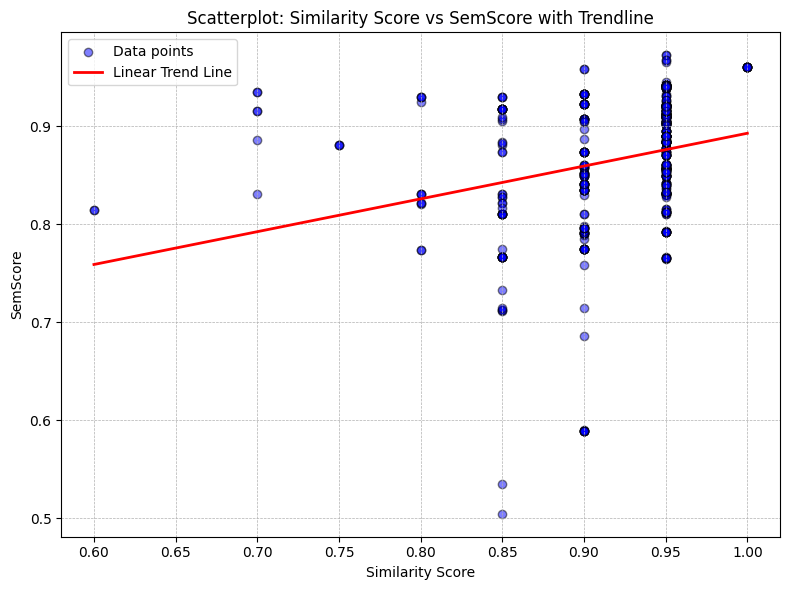

In [90]:
# Dados
x = df_agree['similarity_score']
y = df_agree['semscore']

# Criar o gráfico de dispersão
plt.figure(figsize=(8, 6))  # Tamanho do gráfico
plt.scatter(x, y, alpha=0.5, color="blue", edgecolor="k", label="Data points")

# Adicionar linha de tendência linear
slope, intercept, _, _, _ = linregress(x, y)
x_line = np.linspace(min(x), max(x), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color="red", linewidth=2, label="Linear Trend Line")

# Melhorar a grid com intervalos mais detalhados
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Adicionar título e rótulos
plt.title('Scatterplot: Similarity Score vs SemScore with Trendline')
plt.xlabel('Similarity Score')
plt.ylabel('SemScore')
plt.legend()  # Mostrar legenda

# Mostrar o gráfico
plt.tight_layout()
plt.show()



A correlation of -0.107 indicates a weak negative linear relationship between the variables, suggesting that as one variable slightly increases, the other tends to decrease marginally. However, the relationship is negligible, indicating little to no linear association. This weak correlation implies that changes in one variable do not reliably predict changes in the other. Furthermore, the low magnitude does not preclude the possibility of a non-linear relationship, which would require alternative methods of analysis for detection.

### Prompt analysis

Analyze number of tokens from prompts and documents from last checkpoint using gpt-4o as a reference model.

According to [OpenAI | models](https://platform.openai.com/docs/models), the maximum number of tokens (context length) for gpt-4o is 128k.

The cost to use gpt-4o is 2.50 USD per 1m tokens in 2024-10-31. Source: [OpenAI | pricing](https://openai.com/pricing).

Extract elapse times and completions from all sessions.

In [91]:
managers, file_info_list = get_all_checkpoints(config["DEFAULT_CHECKPOINT_DIR"])

2024-12-22 01:04:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-08-1.json
2024-12-22 01:04:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-08-10.json
2024-12-22 01:04:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-08-2.json
2024-12-22 01:04:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-08-3.json
2024-12-22 01:04:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-08-4.json
2024-12-22 01:04:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-08-5.json
2024-12-22 01:04:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-08-6.json
2024-12-22 01:04:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-12-08-7.json
2024-12-22 01:04:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-

In [92]:
tokens_eval = {"doc_type": [], "elapsed_times": [], "completions": [], "file_infos": []}

for manager, file_info in zip(managers, file_info_list):
    # Process documents
    for key in manager.model_dump()["documents"].keys():
        if key[1].startswith("llm_"):
            doc = manager.retrieve_document(key[0], key[1])
            logger.info(f"Processing: {key[0]}, {key[1]}")
            elapsed_times = doc.elapsed_times
            logger.debug(f"Elapsed time: {elapsed_times}")
            completions = doc.completions
            logger.debug(f"Completions: {completions}")
            tokens_eval["doc_type"].append(key[1])
            tokens_eval["elapsed_times"].append(elapsed_times)
            tokens_eval["completions"].append(completions)
            tokens_eval["file_infos"].append(file_info)
logger.info(f"Executions for evaluation: {len(tokens_eval['doc_type'])}")

2024-12-22 01:04:04 - INFO - Processing: § 275.0-2_P1, llm_response
2024-12-22 01:04:04 - INFO - Processing: § 275.0-2_P2, llm_response
2024-12-22 01:04:04 - INFO - Processing: § 275.0-5_P1, llm_response
2024-12-22 01:04:04 - INFO - Processing: § 275.0-5_P2, llm_response
2024-12-22 01:04:04 - INFO - Processing: § 275.0-7_P1, llm_response
2024-12-22 01:04:04 - INFO - Processing: § 275.0-7_P2, llm_response
2024-12-22 01:04:04 - INFO - Processing: classify_P1, llm_response_classification
2024-12-22 01:04:04 - INFO - Processing: classify_P2_Operative_rules, llm_response_classification
2024-12-22 01:04:04 - INFO - Processing: classify_P2_Definitional_terms, llm_response_classification
2024-12-22 01:04:04 - INFO - Processing: classify_P2_Definitional_names, llm_response_classification
2024-12-22 01:04:04 - INFO - Processing: classify_P2_Definitional_facts, llm_response_classification
2024-12-22 01:04:04 - INFO - Processing: transform_Operative_Rules, llm_response_transform
2024-12-22 01:04:0

Evaluate

In [93]:
# Constants
reference_models = config["REFERENCE_MODELS"]["MAX_CONTEXT_LENGTH"]
price_per_million_tokens = config["REFERENCE_MODELS"]["PRICE_PER_MILLION_TOKENS"]

# Initialize an empty list to store the raw data
raw_data = []

# Assuming tokens_eval is already defined and contains the necessary data
for doc_type, elapsed_times, completions, file_info in zip(
    tokens_eval["doc_type"],
    tokens_eval["elapsed_times"],
    tokens_eval["completions"],
    tokens_eval["file_infos"],
):
    for elapsed_time, completion in zip(elapsed_times, completions):
        raw_data.append(
            (
                file_info["filename"],
                doc_type,
                elapsed_time,
                completion["usage"],
                completion["created"],
                completion["model"],
            )
        )

prompt_data_df = prompt_analysis(raw_data, config["DEFAULT_OUTPUT_DIR"])


Overall Statistics:
 Total Tokens  Number of Samples  Average Elapsed Time (s)  Estimated Cost (USD)  Average Percentage of Context Length (%) Min Created Timestamp Max Created Timestamp                      origin              run_at
      5472633               1210                  4.055949             13.681582                                  3.533467   2024-11-30 00:08:20   2024-12-15 03:44:41 documents-2024-12-08-9.json 2024-12-22 01:04:04

Statistics by Sample Type (doc_type):
                   doc_type  total_tokens  num_samples  average_elapsed_time  average_tokens  estimated_cost  average_percentage_context_length                    filename              run_at
               llm_response        272850           60             28.951583     4547.500000        0.682125                           3.552734 documents-2024-12-08-9.json 2024-12-22 01:04:04
llm_response_classification        370390           50              8.280727     7407.800000        0.925975                  

In [94]:
prompt_data_df.describe()

elapsed_time                        created  completion_tokens  \
count   1210.000000                           1210        1210.000000   
mean       4.055949  2024-12-11 08:39:27.552892416         314.194215   
min        1.502028            2024-11-30 00:08:20         131.000000   
25%        2.005183            2024-12-09 01:54:09         156.000000   
50%        2.466322            2024-12-09 01:55:39         173.000000   
75%        2.913875  2024-12-15 03:16:51.750000128         200.000000   
max       43.604876            2024-12-15 03:44:41        4517.000000   
std        6.358610                            NaN         588.970664   

       prompt_tokens  total_tokens  reference_context_length  \
count    1210.000000    1210.00000                    1210.0   
mean     4208.642975    4522.83719                  128000.0   
min      1357.000000    1501.00000                  128000.0   
25%      2337.000000    4597.00000                  128000.0   
50%      4722.000000    5127.00000                  128000.0   
75%      5074.000000    5257.00000                  128000.0   
max      8120.000000    8590.00000                  128000.0   
std      1557.668782    1508.34103                       0.0   

       price_per_million_tokens  tokens_per_second  
count                    1210.0        1210.000000  
mean                        2.5        1802.337863  
min                         2.5         127.116341  
25%                         2.5        1056.751444  
50%                         2.5        1891.422901  
75%                         2.5        2480.162415  
max                         2.5        3466.646635  
std                         0.0         857.387664

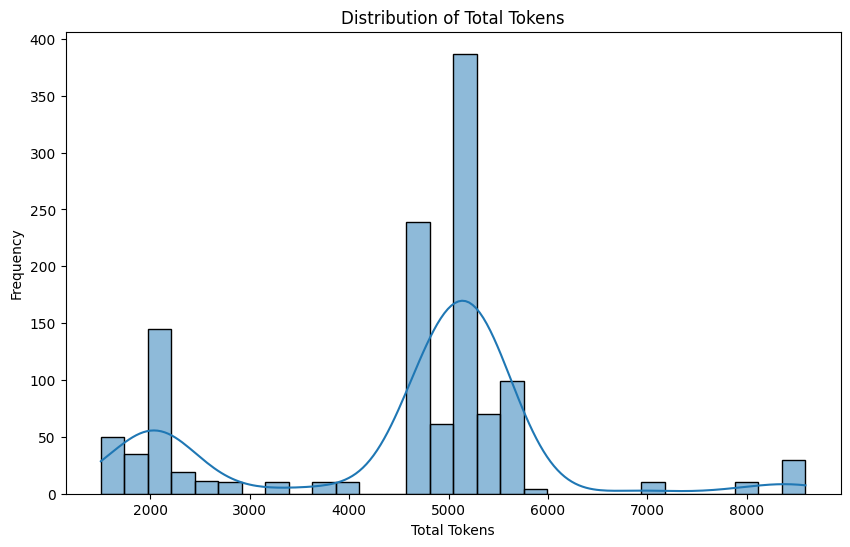

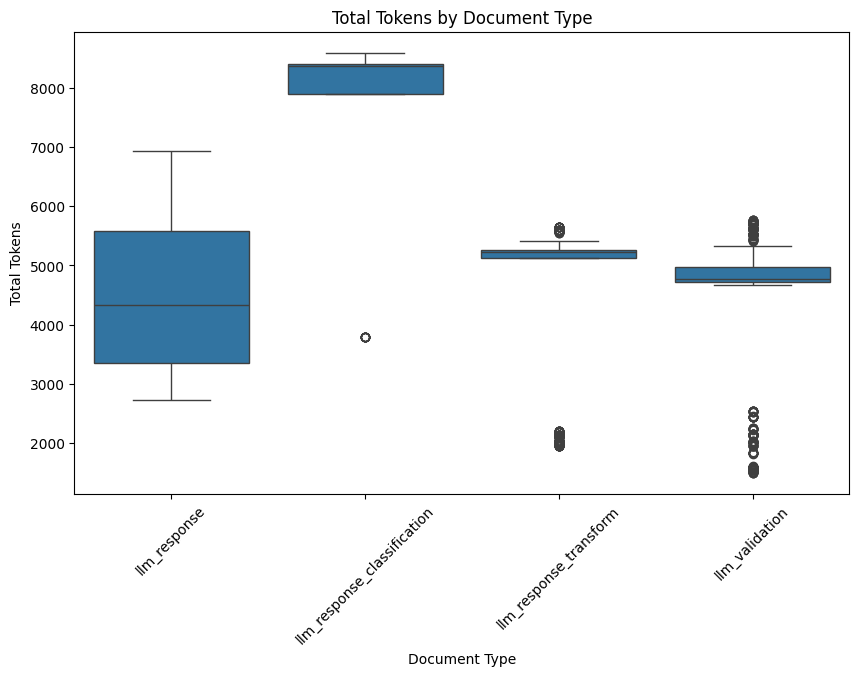

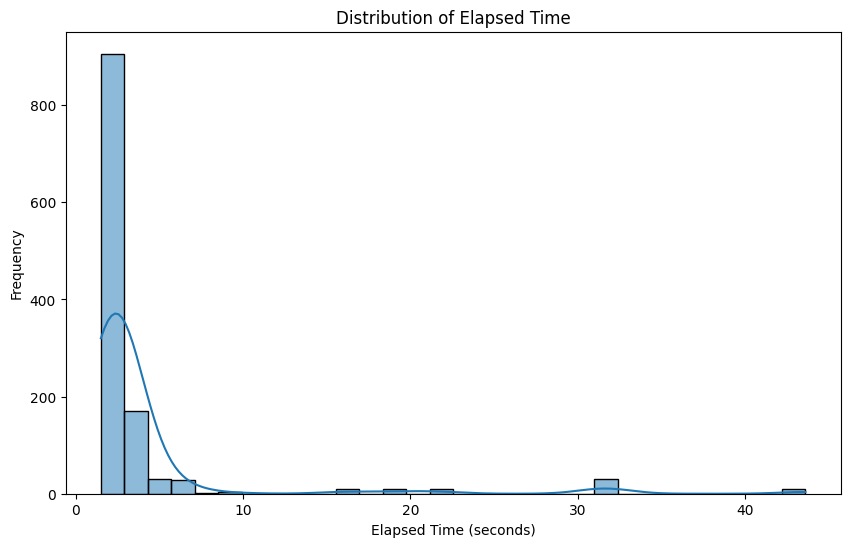

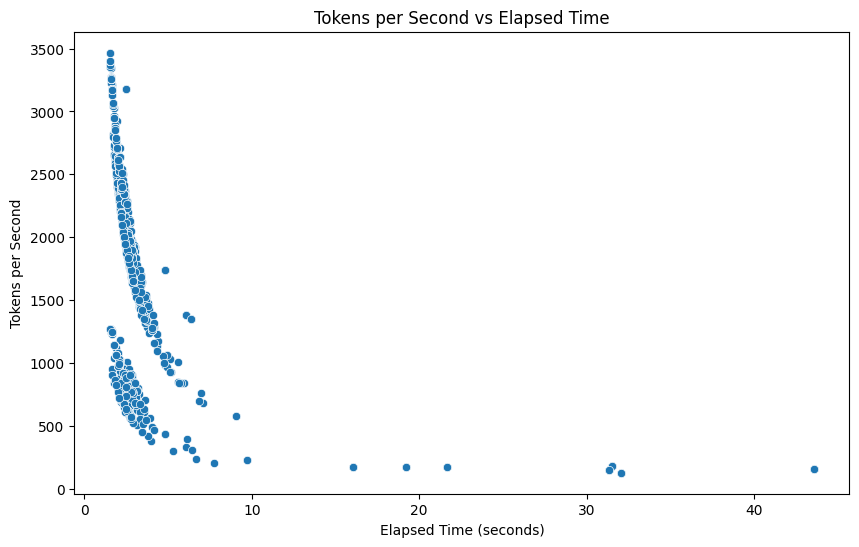

2024-12-22 01:04:06 - INFO - Total cost: $13.68


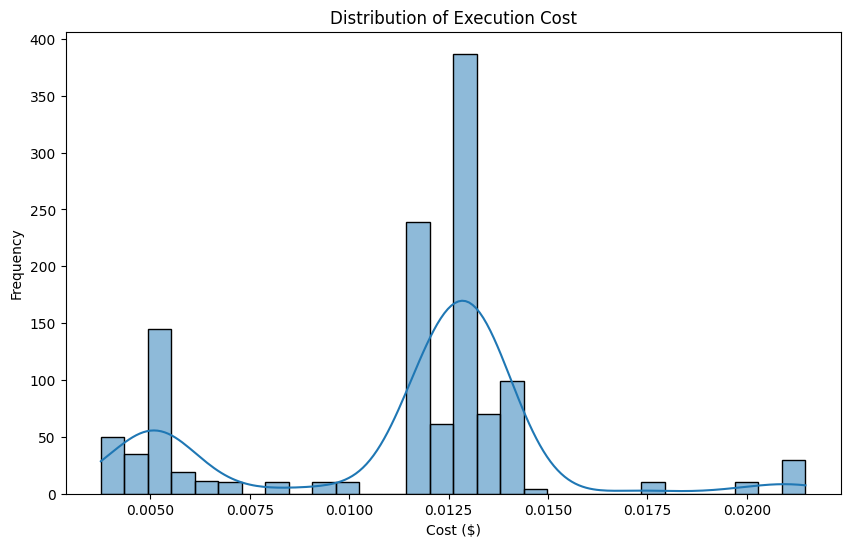

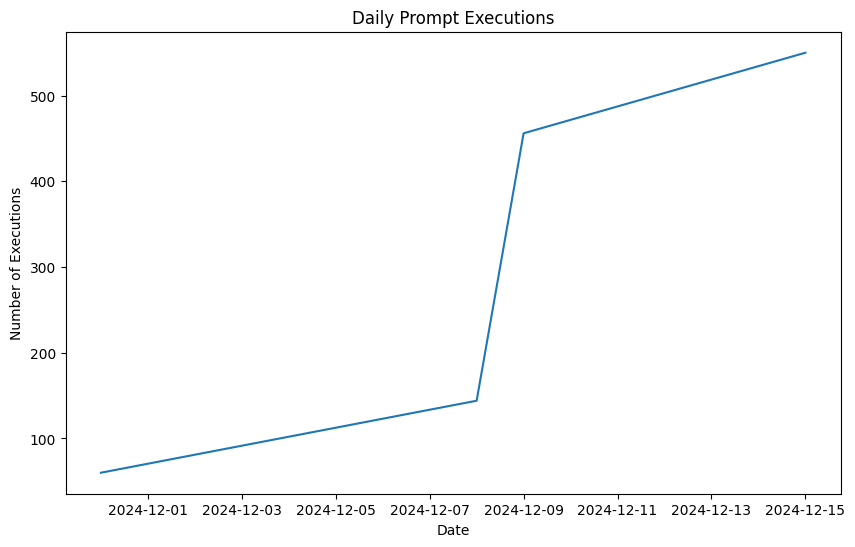

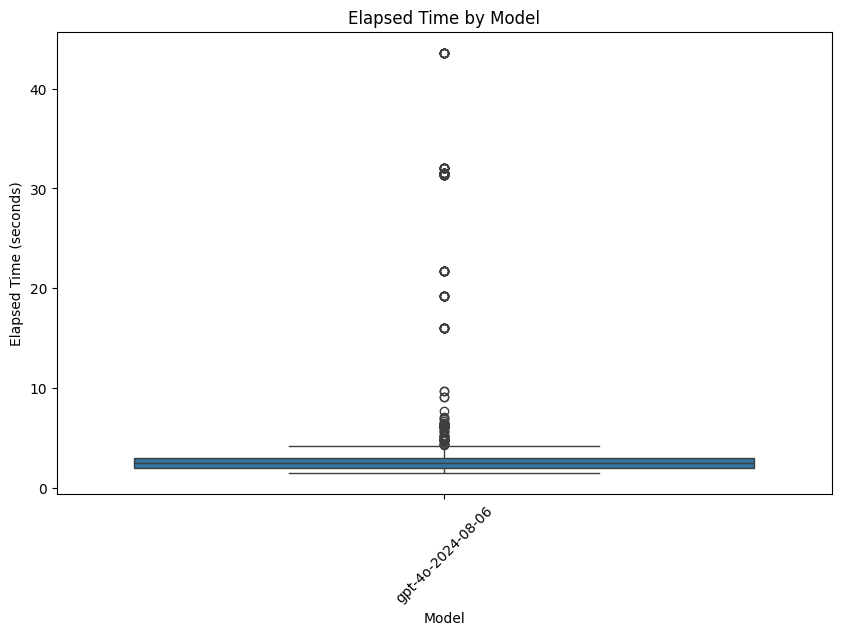

In [95]:
# Running the analysis
stats = summary_statistics(prompt_data_df)
token_usage_analysis(prompt_data_df)
time_efficiency_analysis(prompt_data_df)
cost_analysis(prompt_data_df)
temporal_analysis(prompt_data_df)
group_performance_analysis(prompt_data_df)

In [96]:
stats

elapsed_time                        created  completion_tokens  \
count   1210.000000                           1210        1210.000000   
mean       4.055949  2024-12-11 08:39:27.552892416         314.194215   
min        1.502028            2024-11-30 00:08:20         131.000000   
25%        2.005183            2024-12-09 01:54:09         156.000000   
50%        2.466322            2024-12-09 01:55:39         173.000000   
75%        2.913875  2024-12-15 03:16:51.750000128         200.000000   
max       43.604876            2024-12-15 03:44:41        4517.000000   
std        6.358610                            NaN         588.970664   

       prompt_tokens  total_tokens  reference_context_length  \
count    1210.000000    1210.00000                    1210.0   
mean     4208.642975    4522.83719                  128000.0   
min      1357.000000    1501.00000                  128000.0   
25%      2337.000000    4597.00000                  128000.0   
50%      4722.000000    5127.00000                  128000.0   
75%      5074.000000    5257.00000                  128000.0   
max      8120.000000    8590.00000                  128000.0   
std      1557.668782    1508.34103                       0.0   

       price_per_million_tokens  tokens_per_second  
count                    1210.0        1210.000000  
mean                        2.5        1802.337863  
min                         2.5         127.116341  
25%                         2.5        1056.751444  
50%                         2.5        1891.422901  
75%                         2.5        2480.162415  
max                         2.5        3466.646635  
std                         0.0         857.387664